In [1]:
# install dependencies
#
# this will automatically install the extra packages
# not in sage-9.2 that you still require
!pip install --upgrade pip
!pip install tqdm
!pip install dotmap
!pip install joblib
!pip install dill

Compiling /home/jupyter/base/compinvmeas-python/Python/cython_sparse_mat_vec.spyx...
Compiling /home/jupyter/base/compinvmeas-python/Python/binsearch2.spyx...


System's min expansivity: 1.171751392453530?
Graph:
  system: x |-> 2*x + 0.0393275800000000*sin(4*pi*x) + 0.0531647000000000*sin(2*pi*x) + 0.347000000000000


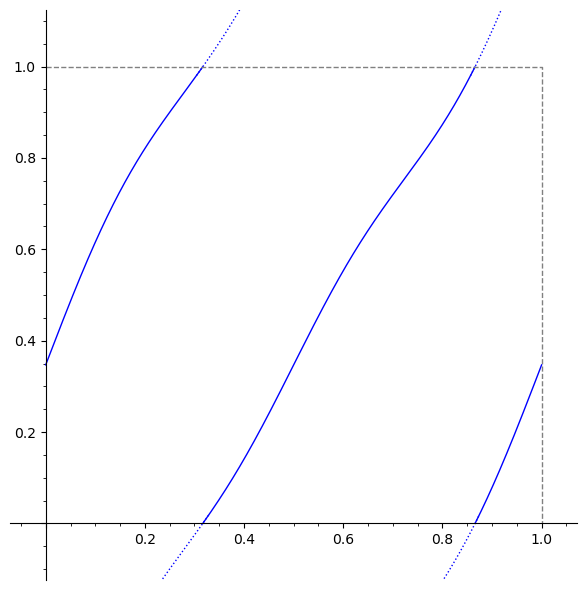

In [2]:
import sys, os; sys.path.append(os.path.abspath('Python'))

# [Cell 1]
# this module allows to run each cell displaying at the same time the global variable used,
# useful to catch if we use old variables without noticing
import inspection_magics
inspection_magics.set_defaults('--no-funcs --no-mods --exclude-mods=sage --show-values')

# this facility memoizes the results of compute functions in sqlite database 'db.db'
from memoize_db import *
# to clear the whole db: rm -f db.db

# allows to clear unused entries with the command below
# MemoDB.instance().enable_tracking()
# MemoDB.instance().clear_not_accessed() # AFTER a run of the notebook

#the numpy numerical library
import numpy as np, math, random, time
from IPython.display import clear_output

# library containing the dynamic
from dynamic import *

# library to plot the measure
from plotting import *


# D represents the dynamical system, will be x -> Qx + c*sin(j*pi*x) + c2*sin(j2*pi*x) + k
D_Q = 2
D_j = 4
D_c = 0.03932758
D_j2 = 2
D_c2 = 0.0531647
D_k  = 0.347

D = PerturbedQWxDynamic(Q=D_Q,j=D_j,c=D_c,j2=D_j2,c2=D_c2, k=D_k)
D_desc = "{Q}*x + {c}*sin({j}*pi*x) + {c2}*sin({j2}*pi*x) + {k}".format(
            Q=D_Q,j=D_j,c=D_c,j2=D_j2,c2=D_c2, k=D_k)
print("System's min expansivity:", D.expansivity())

# utility to plot the dynamical sytem
def plot_dynamics(D, resolution=2000):
    pl = plot([])
    for b in range(D.nbranches):
        pl += line([(x, y) for x,y in ((float(i/resolution), D.f_unquotiented(D.field(i/resolution))-b)
                                        for i in range(resolution+1))
                   if -0.15 < y < 0.02], 
                   color='blue', linestyle=':')
        pl += line([(x, y) for x,y in ((float(i/resolution), D.f_unquotiented(D.field(i/resolution))-b)
                                        for i in range(resolution+1))
                   if 0.98 < y < 1.15], 
                   color='blue', linestyle=':')
        pl += line([(x, y) for x,y in ((float(i/resolution), D.f_unquotiented(D.field(i/resolution))-b)
                                        for i in range(resolution+1))
                   if y >-0.0001 and y<1.0001], 
                   color='blue')
    pl += line([(0,1), (1,1), (1,0)], color='grey', linestyle='--')
    pl.show(figsize=[6,6], xmin=-0.05, xmax=1.05, ymin=-0.1, ymax=1.1)

print("Graph:")
print(f"  system: x |-> {D_desc}")
plot_dynamics(D)

In [3]:
%%open_vars

# [Cell 2]
# libraries for the ulam approximation
from partition import *
from ulam import *

# generic libraries containing the generic assembler for the matrices, 
# the decay time estimator and the library that estimates the error
from generic_assembler import *
from decay import *
from generic_estimator import *

# library for operation for sparse matrices (in particular sage_sparse_to_scipy_sparse)
from sparse import *
from dotmap import DotMap

from typing import List, Tuple, Union
Int = Union[int, Integer]

# computes the Perron-Frobenius operator, a square matrix P of size precMeas, and the SRB measure
# returns a map with possible fields: 'Perron' (Perron operator), 'srb' (SRB measure), 'res' (residual)
def compute_perron_frobenius(D, measure_prec: Int, silent:bool=False, compute_srb:bool=False, rigorous:bool=False):
    if not silent:
        print("Computing Perron-Frobenius operator, prec:", measure_prec)
    b_Ulam = UlamL1(equispaced(measure_prec))
    Psage = assemble(
            dynamic = D,
            basis = b_Ulam,
            epsilon = 0.000000000001,
            output_rate=(0 if silent else (measure_prec//4))
        )

    if compute_srb and rigorous:
        decTime=decay_time(D, b_Ulam, Psage)

    P = sage_sparse_to_scipy_sparse(Psage)
    retv = DotMap(Perron=P)

    if compute_srb:
        srb=np.ones(measure_prec)/measure_prec

        # power method
        for i in range(decTime*10 if rigorous else 500):
            srb=P*srb

        retv.srb = srb
            
        if rigorous:
            retv.res = b_Ulam.residual_estimate(Psage, srb)

            # estimating the error
            retv.error_bound = error_bound_from_decay_time(D, b_Ulam, decTime, 0.5, retv.res)

    if not silent:
        clear_output()
        print("Done computing Perron-Frobenius operator, prec:", measure_prec)
        if compute_srb and rigorous:
            print("Decay time:", decTime)
            print("Error bound:", retv.error_bound)
            
    return retv

(no used vars)


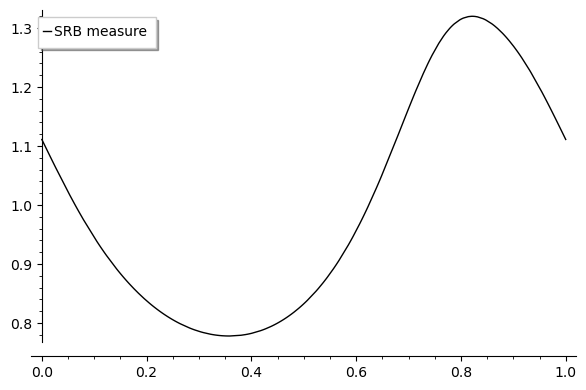

Chart:
  SRB and initial Lebesgue iterates
  measure_prec=55913 (order of Perron operator, precision of measures)


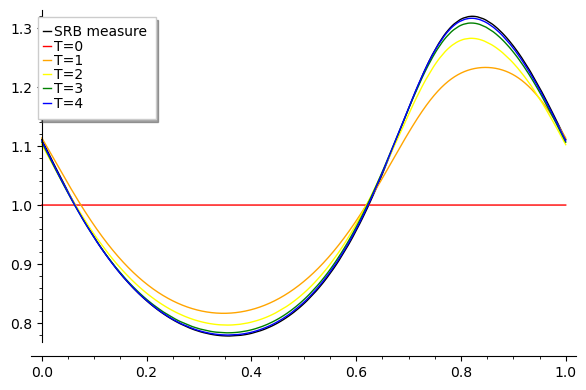

(no used vars)


In [4]:
%%open_vars

# [Cell 3]
# Utility to print description of perturbed system
# As before, the dynamical system, will be x -> Qx + c*sin(j*pi*x) + c2*sin(j2*pi*x) + k
# Perturbed parameters are: c, c2 and k
def perturbed_system_desc(perturb1=0.0, perturb2=0.0, perturb3=0.0, **kwargs):
    assert(-1 <= perturb1 <= 1)
    assert(-1 <= perturb2 <= 1)
    assert(-1 <= perturb3 <= 1)
    c = D_c + 0.001 * perturb1
    c2 = D_c2 + 0.001 * perturb2
    k = D_k + 0.01 * perturb3
    retv = "{Q}*x + {c}*sin({j}*pi*x) + {c2}*sin({j2}*pi*x) + {k}".format(
            Q=D_Q, j=D_j, c=c, j2=D_j2, c2=c2, k=k)

# Utility to compute perturbed system
# Returns the dynamical system with (optional) perturbations
def perturbed_system(perturb1=0.0, perturb2=0.0, perturb3=0.0, **kwargs):
    assert(-1 <= perturb1 <= 1)
    assert(-1 <= perturb2 <= 1)
    assert(-1 <= perturb3 <= 1)
    c = D_c + 0.001 * perturb1
    c2 = D_c2 + 0.001 * perturb2
    k = D_k + 0.01 * perturb3
    return PerturbedQWxDynamic(Q=D_Q, j=D_j, c=c, j2=D_j2, c2=c2, k=k)

# Returns perron/srb, with memoization (optional args: perturb1,2,3)
@memodb
def system_perron_srb(measure_prec, **kwargs):
    D = perturbed_system(**kwargs)
    res = compute_perron_frobenius(D, measure_prec, compute_srb=True, silent=True)
    return res.Perron, res.srb

# NOTATION: T is the iteration number, ie (T)ime
# return Lebesgue iterate, with memoization (optional args: perturb1,2,3)
@memodb
def lebesgue_iterate(measure_prec: Int, T: Int, **kwargs):
    if T == 0:
        return np.ones(measure_prec)/measure_prec
    else:
        P, _ = system_perron_srb(measure_prec, **kwargs)
        meas = lebesgue_iterate(measure_prec, T-1, **kwargs)
        return P * meas

# helper, turns a measure to a plot
def plot_measure(data, **kwargs):
    n = len(data)
    return line([((i+0.5) / n, x * n) for i, x in enumerate(data)], **kwargs)

# small test, chart srb and some iterates
measure_prec = 11*13*17*23 
P, srb = system_perron_srb(measure_prec)
pl = plot_measure(srb, legend_label="SRB measure", color="black")
pl.save('Images/DensitySRB.png',dpi=200)
pl.show()
pl += plot_measure(lebesgue_iterate(measure_prec, 0), legend_label="T=0", color="red")
pl += plot_measure(lebesgue_iterate(measure_prec, 1), legend_label="T=1", color="orange")
pl += plot_measure(lebesgue_iterate(measure_prec, 2), legend_label="T=2", color="yellow")
pl += plot_measure(lebesgue_iterate(measure_prec, 3), legend_label="T=3", color="green")
pl += plot_measure(lebesgue_iterate(measure_prec, 4), legend_label="T=4", color="blue")

print("Chart:")
print("  SRB and initial Lebesgue iterates")
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
pl.show()
pl.save('Images/DensitySRB2.png',dpi=200)

Chart:
  first discretization `MapToClosest` iterates
  N=100000 (grid size)
  smooth=500 (smoothing range)
  measure_prec=55913 (order of Perron operator, precision of measures)


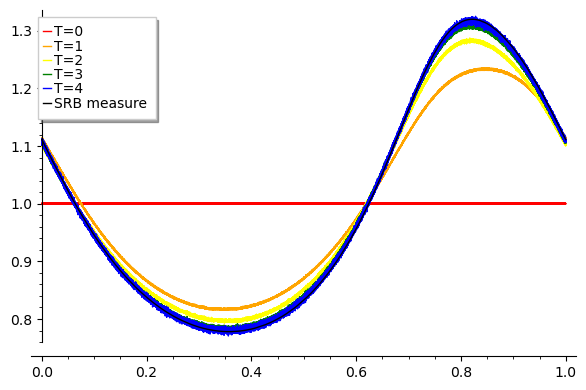

used vars: measure_prec=55913, srb=[1.98722758e-05 1.98716835e-05 1.98711499e-05 ... 1.98740769e-05
 1.98735067e-05 1.98728885e-05]


In [5]:
%%open_vars

# [Cell 4]
# the discretizations are defined in discretizations.py
# OnceDecidedRandom:
#   A once-randomized discretization of the map: for i such that i/N < f(x) < (i+1)/N,
#   is chosen once and for all to be i/N with prob (i+1)-N*f(x) and (i+1)/N with prob N*f(x)-i.
# MapToCombination:
#   measure on the grid is split: a delta_x is sent on the measure
#   p*delta_{i/N} + (1-p)*delta_{(i+1)/N}, with i/N < f(x) < (i+1)/N, and p = (i+1)-N*f(x)
# MapToClosest: 
#   Sent to closest grid element
# StepwiseRandom:
#   At each step, the point is sent to a random one between the two closest points, points merge
# PointsRandomOnGrid:
#   PointSet - All N points are travelling independently at random (that is, deltas are split)
# PointsPerturbed:  
#   PointSet - All points are travelling independently outside any grid, with random perturbation of size 1/N
discretizations = [
    'OnceDecidedRandom',
    'MapToCombination',
    'MapToClosest',
    'StepwiseRandom',
    'PointsRandomOnGrid',
    'PointsPerturbed']
def get_discretization(discr_type: str):
    import discretization
    return discretization.__dict__[discr_type]

# there are two distance functions:
# DiscrepancyCircle #
#   The discrepancy distance used in the paper
# WassersteinDistCircle #
#   The classical L^1 Wasserstein distance
discrete_distances = [
    'DiscrepancyCircle',
    'WassersteinDistCircle']
def get_discrete_distance(dist_type: str):
    import discrete_distance
    return discrete_distance.__dict__[dist_type]

# NOTE: here "MemoDB" is FUNDAMENTAL for the once decided random obejct, it
# makes sure it is initialized only once (if not, a new object has a different
# randomization)
@memodb
def build_discretized_system(discr_type, N, **kwargs):
    # print("creating new system:", [discr_type, N, kwargs])
    discretiz = get_discretization(discr_type)
    return discretiz(perturbed_system(**kwargs), N)

# NOTATION: we call N the size of the discretization
# returns the T-th iteration of the discretization discr_type on a grid of size N
# optional extra args: perturb1,2,3
@memodb
def discretization_iterate(discr_type: str, N: Int, T: Int, **kwargs):
    # print("iterate", T, " for system:", [discr_type, N, kwargs])
    discretized_system = build_discretized_system(discr_type, N, **kwargs)
    if T == 0:
        return discretized_system.initial_equidistributed()
    else:
        prev_iterate_status = discretization_iterate(discr_type, N, T-1, **kwargs)
        return discretized_system.push_forward(prev_iterate_status)

# the discretized system iterate, converted to a measure of size `measure_prec`
@memodb
def discrit_as_meas(discr_type: str, measure_prec: Int, N: Int, T: Int, **kwargs):
    discretized_system = build_discretized_system(discr_type, N, **kwargs)
    iterate_status = discretization_iterate(discr_type, N, T, **kwargs)
    
    tmp_meas = np.ndarray(measure_prec)
    discretized_system.to_measure(iterate_status, tmp_meas)
    return tmp_meas

# the discretized system iterate, converted to a measure of size `measure_prec`
@memodb
def cesaro_discrit_as_meas(discr_type: str, measure_prec: Int, N: Int, T0: Int, T: Int, **kwargs):
    return sum(discrit_as_meas(discr_type, measure_prec, N, t, **kwargs) for t in range(T0, T+1)) / (T+1-T0)

# the distance `dist_type` computed between the lebesge iterate and discrete iterate
@memodb
def distance_discrit_to_lebit(dist_type: str, discr_type: str, measure_prec: Int, N: Int, T: Int, **kwargs):
    meas = discrit_as_meas(discr_type, measure_prec, N, T, **kwargs)
    meas -= lebesgue_iterate(measure_prec, T, **kwargs)
    dist = get_discrete_distance(dist_type)
    return dist(meas)

# distance of discretized iterate to srb
@memodb
def distance_discrit_to_srb(dist_type: str, discr_type: str, measure_prec: Int, N: Int, T: Int, **kwargs):
    meas = discrit_as_meas(discr_type, measure_prec, N, T, **kwargs)
    P, srb = system_perron_srb(measure_prec, **kwargs)
    meas -= srb
    dist = get_discrete_distance(dist_type)
    return dist(meas)

# distance of lebesgue iterate to srb
@memodb
def distance_lebit_to_srb(dist_type: str, measure_prec: Int, N: Int, T: Int, **kwargs):
    meas = lebesgue_iterate(measure_prec, T, **kwargs)
    P, srb = system_perron_srb(measure_prec, **kwargs)
    meas -= srb
    dist = get_discrete_distance(dist_type)
    return dist(meas)

def cyclic_convolve(a, k):
    return np.convolve(np.concatenate((a[-len(k)//2:],a,a[:(len(k)-1)//2])), k, mode='valid')


# small test, plot the smoothed (colvolved) discretization iterates of type "MapToClosest"

smooth = 500
conv = np.ones(smooth)/smooth
discr_type = 'MapToClosest'
N = 10**5

pl = plot_measure(cyclic_convolve(discrit_as_meas(discr_type, measure_prec, N=N, T=0), conv), legend_label="T=0", color="red")
pl += plot_measure(cyclic_convolve(discrit_as_meas(discr_type, measure_prec, N=N, T=1), conv), legend_label="T=1", color="orange")
pl += plot_measure(cyclic_convolve(discrit_as_meas(discr_type, measure_prec, N=N, T=2), conv), legend_label="T=2", color="yellow")
pl += plot_measure(cyclic_convolve(discrit_as_meas(discr_type, measure_prec, N=N, T=3), conv), legend_label="T=3", color="green")
pl += plot_measure(cyclic_convolve(discrit_as_meas(discr_type, measure_prec, N=N, T=4), conv), legend_label="T=4", color="blue")

pl += plot_measure(srb, legend_label="SRB measure", color="black")

print("Chart:")
print(f"  first discretization `{discr_type}` iterates")
print(f"  N={N} (grid size)")
print(f"  smooth={smooth} (smoothing range)")
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
pl.show()
pl.save('Images/DensityFirstIterates.png',dpi=200)

Chart:
  values of cyclic convolution of (`MapToClosest` iterate) - (Lebesgue iterate)
  N=100000 (grid size)
  smooth=500 (smoothing range)
  measure_prec=55913 (order of Perron operator, precision of measures)


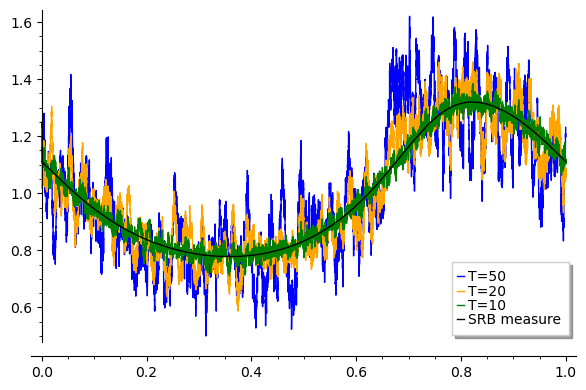

used vars: measure_prec=55913, discr_type=MapToClosest


In [6]:
%%open_vars

# [Cell 5]
# plot the smoothed (colvolved) discretization iterates of type "MapToClosest"
# for different time samples (in T_cols)

N = 10**5
smooth=500
conv = np.ones(smooth)/smooth

P, srb = system_perron_srb(measure_prec)
pl = plot([])
T_cols = [(50, 'blue'), (20, 'orange'), (10, 'green')]
for T, col in T_cols:
    pl += plot_measure(cyclic_convolve(discrit_as_meas(discr_type, measure_prec, N=N, T=T), conv), color=col, legend_label=f'T={T}')
pl += plot_measure(srb, color='black', legend_label='SRB measure')

print("Chart:")
print(f"  values of cyclic convolution of (`{discr_type}` iterate) - (Lebesgue iterate)")
print(f"  N={N} (grid size)")
print(f"  smooth={smooth} (smoothing range)")
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
pl.show()
pl.save('Images/DensityOtherIterates.png',dpi=200)

Chart:
  values of cumulated sums of (`MapToClosest` iterate) - (Lebesgue iterate)
  N=46000 (grid size)
  smooth=500 (smoothing range)
  measure_prec=55913 (order of Perron operator, precision of measures)


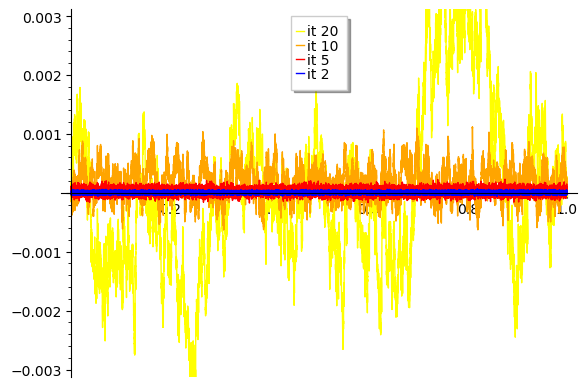

used vars: discr_type=MapToClosest, measure_prec=55913, smooth=500


In [7]:
%%open_vars

# [Cell 6]
# plot cumulated sum of difference (discretized iterated) - (lebesgue iterate)

N = 46000

def as_func(data):
    n = len(data)
    return [((i+0.5)/n,x) for i, x in enumerate(data)]

pl = plot([])
T_cols = [(20, 'yellow'), (10, 'orange'), (5, 'red'), (2, 'blue')]
for T, col in T_cols:
    pl += line(as_func(np.cumsum(discrit_as_meas(discr_type, measure_prec, N=N, T=T)
                         - lebesgue_iterate(measure_prec, T=T))),
          legend_label=f"it {T}", color=col)

print("Chart:")
print(f"  values of cumulated sums of (`{discr_type}` iterate) - (Lebesgue iterate)")
print(f"  N={N} (grid size)")
print(f"  smooth={smooth} (smoothing range)")
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
pl.show(ymin=-0.003, ymax=0.003)
pl.save('Images/DensityCumulated.png',dpi=200, ymin=-0.003, ymax=0.003)


Chart:
  Histogram of cum-sums of (MapToClosest's iterate) - (Lebesgue iterate)
  T=4
  N=2500000 (discretized grid size)
  measure_prec=55913 (order of Perron operator, precision of measures)
  fitted value of sigma: 1.6292460805420936
  predicted standard deviation: 1.619976451720393


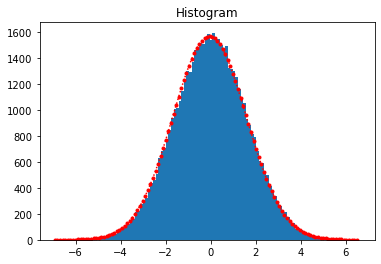

used vars: measure_prec=55913


In [8]:
%%open_vars

# [Cell 6]
# plot values in cumulated sum of difference as above, in a histgram

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

discr_type = 'MapToClosest'
dist_type = 'DiscrepancyCircle'
T=int(4)
N=2500000

discr_measure = discrit_as_meas(discr_type, measure_prec, N=N, T=T)
lebit = lebesgue_iterate(measure_prec, T=T)

a = N * np.cumsum(discr_measure - lebit)
a -= np.average(a)
b, c, d = plt.hist(a, bins='auto')  # arguments are passed to np.histogram

def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x-x0)**2/(2*sigma**2))

predicted_sigma = N * distance_discrit_to_lebit(dist_type, discr_type,
                                                measure_prec, N=N, T=T)

xdata = c[:len(b)]
ydata = b
popt, pcov = curve_fit(gaussian,
                       xdata,
                       ydata,
                       p0=[max(b), 0, predicted_sigma])

print("\nChart:")
print(f"  Histogram of cum-sums of ({discr_type}'s iterate) - (Lebesgue iterate)")
print(f'  T={T}')
print(f'  N={N} (discretized grid size)')
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
print(f'  fitted value of sigma: {popt[2]}')
print(f'  predicted standard deviation: {predicted_sigma}')

plt.plot(xdata, gaussian(xdata, *popt),'ro:',label='fit', markersize=3)
plt.title("Histogram")
plt.show()


Chart:
  Histogram of (MapToClosest's iterate) - (Lebesgue iterate), averaged along 1/40000 of interval
  N=2500000 (discretized grid size)
  measure_prec=55913 (order of Perron operator, precision of measures)
 
  predicted standard deviation: 2.29099266874802
  fitted value of sigma: 2.301887777466016
  T=4


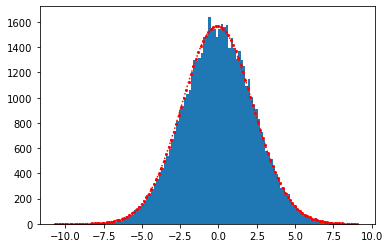

used vars: measure_prec=55913


In [9]:
%%open_vars

# [Cell 7]
# print values in convolution of (discrit - lebit)

discr_type = 'MapToClosest'
dist_type = 'DiscrepancyCircle'
N=2500000

chunk_fraction = 1/40000

print("\nChart:")
print(f"  Histogram of ({discr_type}'s iterate) - (Lebesgue iterate), averaged along {chunk_fraction} of interval")
print(f'  N={N} (discretized grid size)')
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
print(" ")

def cyclic_convolve(a, k):
    return np.convolve(np.concatenate((a[-len(k)//2:],a,a[:(len(k)-1)//2])), k, mode='valid')

#for T in [1,2,3,4,6,8,11,14,18]:
for T in [4]:
    
    discr_measure = discrit_as_meas(discr_type, measure_prec, N=N, T=T)
    lebit = lebesgue_iterate(measure_prec, T=T)
    d = discr_measure - lebit
    M = int(N * chunk_fraction)
    a = N * cyclic_convolve(d, np.ones(M))
    
    b, c, d=plt.hist(a, bins='auto')  # arguments are passed to np.histogram
    
    predicted_sigma = sqrt(2.0) * N * distance_discrit_to_lebit(dist_type, discr_type,
                                                                measure_prec, N=N, T=T)

    xdata = c[:len(b)]
    ydata = b
    popt, pcov = curve_fit(gaussian,
                           xdata,
                           ydata,
                           p0=[max(b), 0, predicted_sigma])
    print(f'  predicted standard deviation: {predicted_sigma}')
    print(f'  fitted value of sigma: {popt[2]}')
    print(f'  T={T}')
    
    plt.plot(xdata, gaussian(xdata, *popt),'ro:',label='fit', markersize=2)
    plt.show()
    plt.close()

OnceDecidedRandom:   0%|          | 0/31 [00:00<?, ?it/s]

MapToCombination:   0%|          | 0/31 [00:00<?, ?it/s]

MapToClosest:   0%|          | 0/31 [00:00<?, ?it/s]

StepwiseRandom:   0%|          | 0/31 [00:00<?, ?it/s]

PointsRandomOnGrid:   0%|          | 0/31 [00:00<?, ?it/s]

PointsPerturbed:   0%|          | 0/31 [00:00<?, ?it/s]


Chart:
  distance `DiscrepancyCircle` of T-th discretized iterate to SRB measure
  T=1,2,...,30
  N=25000 (discretized grid size)
  measure_prec=55913 (order of Perron operator, precision of measures)


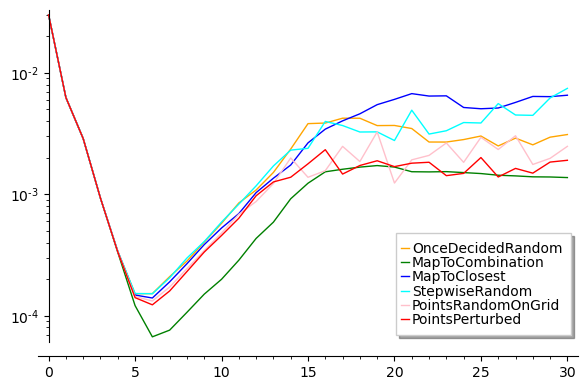

used vars: discretizations=['OnceDecidedRandom', 'MapToCombination', 'MapToClosest', 'StepwiseRandom', 'PointsRandomOnGrid', 'PointsPerturbed'], measure_prec=55913


In [10]:
%%open_vars

# [Cell 8]
# The following graph displays the distance between the discrete measures and the SRB measure
# depending on time, for different types of discretizations

from tqdm.notebook import tqdm
import time

def group_list_by(a, k):
    return [a[i:i+k] for i in range(0, len(a), k)]

def build_list(num_total, enum, desc=None, group_by=None):
    t = tqdm(total=int(num_total), initial=int(0), desc=desc)
    retv = []
    try:
        while True:
            retv.append(next(enum))
            t.update(int(1))
            t.display()
    except StopIteration:
        t.close()
        t.display()
        if group_by is not None:
            retv = group_list_by(retv, group_by)
        return retv

Tmax = 30
dist_type = 'DiscrepancyCircle'
pl = plot([])
N = 25000

# import discretization
for discr_type in discretizations: #for all systems...
    col = get_discretization(discr_type).color
    distances = build_list(Tmax+1, 
                           (distance_discrit_to_srb(dist_type, discr_type,
                                                    measure_prec, N=N, T=T)
                            for T in range(Tmax+1)),
                           desc=discr_type)
    pl += list_plot(distances, plotjoined=True,
                    color = col,
                    legend_label = discr_type)

print(f'\nChart:')
print(f'  distance `{dist_type}` of T-th discretized iterate to SRB measure')
print(f'  T=1,2,...,{Tmax}')
print(f'  N={N} (discretized grid size)')
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
pl.set_legend_options(loc='lower right')
pl.show(scale='semilogy')
pl.save('Images/DiscrepancySRB.png',dpi=200, scale='semilogy')

OnceDecidedRandom:   0%|          | 0/1001 [00:00<?, ?it/s]

MapToCombination:   0%|          | 0/1001 [00:00<?, ?it/s]

MapToClosest:   0%|          | 0/1001 [00:00<?, ?it/s]

StepwiseRandom:   0%|          | 0/1001 [00:00<?, ?it/s]

PointsRandomOnGrid:   0%|          | 0/1001 [00:00<?, ?it/s]

PointsPerturbed:   0%|          | 0/1001 [00:00<?, ?it/s]


Chart:
  distance `DiscrepancyCircle` of T-th discretized iterate to Lebesgue iterate
  T=1,2,...,1000
  N=10000 (discretized grid size)
  measure_prec=55913 (order of Perron operator, precision of measures)


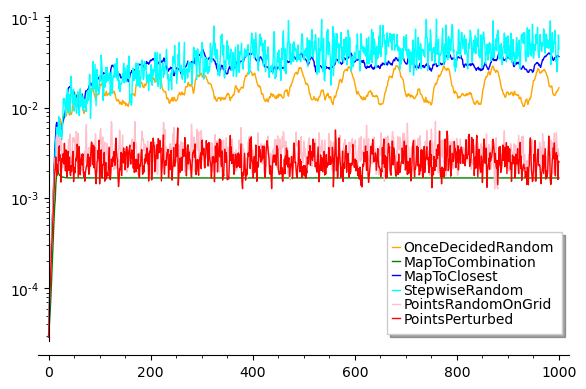

used vars: measure_prec=55913


In [12]:
%%open_vars

# [Cell 9]
# The following graph displays the distance between the discrete measures and the iterates
# of Lebesgue measure under the transfer operator measure depending on time, for different
# types of discretizations

Tmax =1000
dist_type = 'DiscrepancyCircle'
pl = plot([])
N = 10000
discretizations = [
    'OnceDecidedRandom',
    'MapToCombination',
    'MapToClosest',
    'StepwiseRandom',
    'PointsRandomOnGrid',
    'PointsPerturbed'
]

# import discretization
for discr_type in discretizations: #for all systems...
    col = get_discretization(discr_type).color
    distances = build_list(Tmax+1, 
                           (distance_discrit_to_lebit(dist_type, discr_type,
                                                    measure_prec, N=N, T=T)
                            for T in range(Tmax+1)),
                           desc=discr_type)
    pl += list_plot(distances, plotjoined=True,
                    color = col,
                    legend_label = discr_type)

print(f'\nChart:')
print(f'  distance `{dist_type}` of T-th discretized iterate to Lebesgue iterate')
print(f'  T=1,2,...,{Tmax}')
print(f'  N={N} (discretized grid size)')
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
pl.set_legend_options(loc='lower right')
pl.show(scale='semilogy')
pl.save('Images/DiscrepancyIteratesDiscMini.png',dpi=200, scale='semilogy')

OnceDecidedRandom:   0%|          | 0/3001 [00:00<?, ?it/s]

MapToCombination:   0%|          | 0/3001 [00:00<?, ?it/s]

MapToClosest:   0%|          | 0/3001 [00:00<?, ?it/s]

StepwiseRandom:   0%|          | 0/3001 [00:00<?, ?it/s]

PointsRandomOnGrid:   0%|          | 0/3001 [00:00<?, ?it/s]

PointsPerturbed:   0%|          | 0/3001 [00:00<?, ?it/s]


Chart:
  distance `DiscrepancyCircle` of T-th discretized iterate to Lebesgue iterate
  T=1,2,...,3000
  N=500000 (discretized grid size)
  measure_prec=55913 (order of Perron operator, precision of measures)


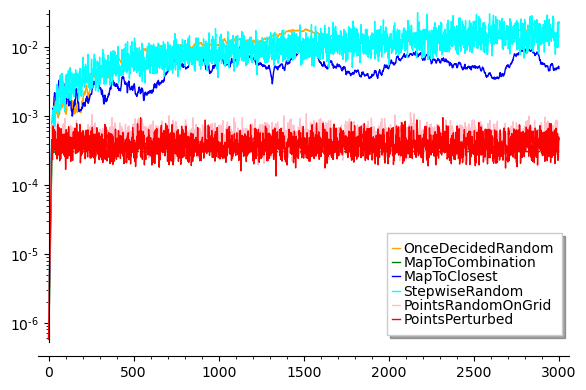

used vars: measure_prec=55913


In [13]:
%%open_vars

# [Cell 10]
# The following graph displays the distance between the discrete measures and the iterates of
# Lebesgue measure under the transfer operator measure depending on time, for different types
# of discretizations

Tmax =3000
dist_type = 'DiscrepancyCircle'
pl = plot([])
N = 500000
discretizations = [
    'OnceDecidedRandom',
    'MapToCombination',
    'MapToClosest',
    'StepwiseRandom',
    'PointsRandomOnGrid',
    'PointsPerturbed'
]

# import discretization
for discr_type in discretizations: #for all systems...
    col = get_discretization(discr_type).color
    distances = build_list(Tmax+1, 
                           (distance_discrit_to_lebit(dist_type, discr_type,
                                                    measure_prec, N=N, T=T)
                            for T in range(Tmax+1)),
                           desc=discr_type)
    pl += list_plot(distances, plotjoined=True,
                    color = col,
                    legend_label = discr_type)

print(f'\nChart:')
print(f'  distance `{dist_type}` of T-th discretized iterate to Lebesgue iterate')
print(f'  T=1,2,...,{Tmax}')
print(f'  N={N} (discretized grid size)')
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
pl.set_legend_options(loc='lower right')
pl.show(scale='semilogy')
pl.save('Images/DiscrepancyIteratesDisc.png', dpi=200, scale='semilogy')

MapToClosest:   0%|          | 0/101 [00:00<?, ?it/s]

MapToClosest:   0%|          | 0/101 [00:00<?, ?it/s]

MapToClosest:   0%|          | 0/101 [00:00<?, ?it/s]

MapToClosest:   0%|          | 0/101 [00:00<?, ?it/s]

MapToClosest:   0%|          | 0/101 [00:00<?, ?it/s]

MapToClosest:   0%|          | 0/101 [00:00<?, ?it/s]

MapToClosest:   0%|          | 0/101 [00:00<?, ?it/s]


Chart:
  distance `DiscrepancyCircle` of T-th discretized iterate to Lebesgue iterate, multiplied by the discretization order N
  T=1,2,...,100
  measure_prec=55913 (order of Perron operator, precision of measures)


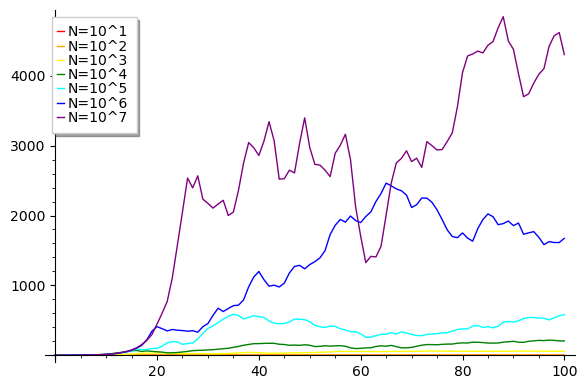

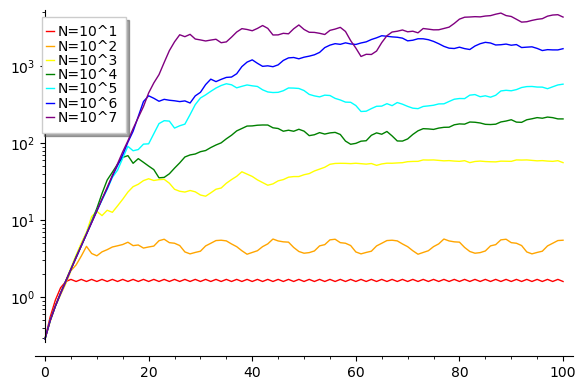

used vars: measure_prec=55913


In [14]:
%%open_vars

# [Cell 11]
# The following graph displays N times the distance between the discrete measures
# and the iterates of Lebesgue measure wrt transfer operator measure depending
# on time, for a single type of discretizations and different discretization orders N

Tmax = 100
dist_type = 'DiscrepancyCircle'
discr_type = 'MapToClosest'
pl = plot([])

N_cols = [
    (10, 'red'), 
    (100, 'orange'),
    (1000, 'yellow'),
    (10000, 'green'),
    (100000, 'cyan'),
    (1000000, 'blue'),
    (10000000, 'purple')
]

# import discretization
for N, col in N_cols: #for all systems...
    distances = build_list(Tmax+1, 
                           (distance_discrit_to_lebit(dist_type, discr_type,
                                                    measure_prec, N=N, T=T)
                            for T in range(Tmax+1)),
                           desc=discr_type)
    dista = [x * N for x in distances]
    pl += list_plot(dista, plotjoined=True,
                    color = col,
                    legend_label = f'N=10^{int(log(N)/log(10))}')

print(f'\nChart:')
print(f'  distance `{dist_type}` of T-th discretized iterate to Lebesgue iterate, multiplied by the discretization order N')
print(f'  T=1,2,...,{Tmax}')
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
pl.set_legend_options(loc='best')
pl.show()
pl.save('Images/DiscrepancyIteratesNNoLog.png',dpi=200)
pl.show(scale='semilogy')
pl.save('Images/DiscrepancyIteratesN.png',dpi=200, scale='semilogy')

N=10:   0%|          | 0/1001 [00:00<?, ?it/s]

N=100:   0%|          | 0/1001 [00:00<?, ?it/s]

N=1000:   0%|          | 0/1001 [00:00<?, ?it/s]

N=10000:   0%|          | 0/1001 [00:00<?, ?it/s]

N=10000:   0%|          | 0/1001 [00:00<?, ?it/s]

N=100000:   0%|          | 0/1001 [00:00<?, ?it/s]

N=1000000:   0%|          | 0/1001 [00:00<?, ?it/s]

N=10000000:   0%|          | 0/1001 [00:00<?, ?it/s]


Chart:
  distance `DiscrepancyCircle` of T-th discretized iterate to Lebesgue iterate, multiplied by the discretization order N
  Top: ormal scale, bottom: y-log scale
  T=1,2,...,1000
  measure_prec=55913 (order of Perron operator, precision of measures)


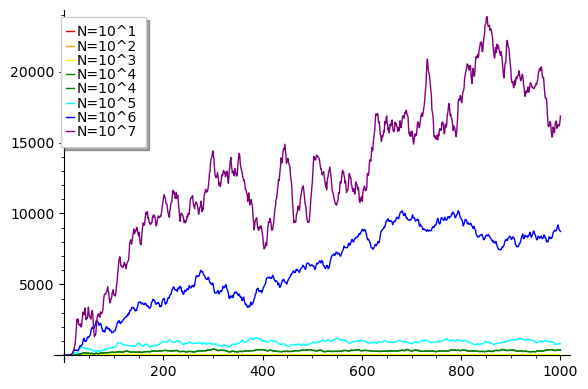

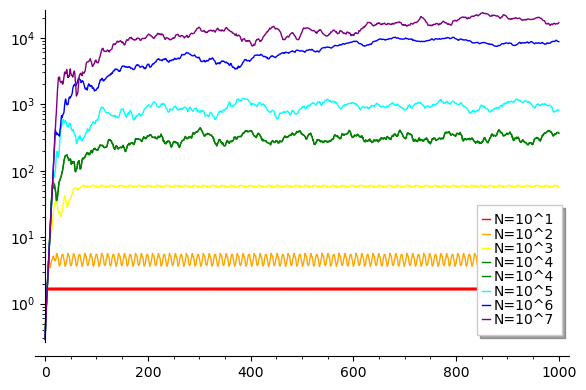

used vars: measure_prec=55913


In [11]:
%%open_vars

# [Cell 12]
# The following graph displays N times the distance between the discrete measures
# and the iterates of Lebesgue measure wrt transfer operator measure depending on time,
# for a single type of discretizations and different discretization orders N
# Like above, different settings.

Tmax = 1000
dist_type = 'DiscrepancyCircle'
discr_type = 'MapToClosest'
pl = plot([])


N_cols = [
    (10, 'red'), 
    (100, 'orange'),
    (1000, 'yellow'),
    (10000, 'green'),
    (10000, 'green'),
    (100000, 'cyan'),
    (1000000, 'blue'),
    (10000000, 'purple') # DISABLE temporarily
]

# import discretization
for N, col in N_cols: #for all systems...
    distances = build_list(Tmax+1, 
                           (distance_discrit_to_lebit(dist_type, discr_type,
                                                    measure_prec, N=N, T=T)
                            for T in range(Tmax+1)),
                           desc=f'N={N}')
    dista = [x * N for x in distances]
    pl += list_plot(dista, plotjoined=True,
                    color = col,
                    legend_label = f'N=10^{int(log(N)/log(10))}')

print(f'\nChart:')
print(f'  distance `{dist_type}` of T-th discretized iterate to Lebesgue iterate, multiplied by the discretization order N')
print(f'  Top: ormal scale, bottom: y-log scale')
print(f'  T=1,2,...,{Tmax}')
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
pl.set_legend_options(loc='upper left')
pl.show()
pl.save('Images/DiscrepancyIteratesBigNNoLog.png',dpi=200)
pl.set_legend_options(loc='lower right')
pl.show(scale='semilogy')
pl.save('Images/DiscrepancyIteratesBigNLog.png',dpi=200, scale='semilogy')

N=10:   0%|          | 0/201 [00:00<?, ?it/s]

For N: 10, min distance at it: 0, log-dist: -3.1803281336992417


N=100:   0%|          | 0/201 [00:00<?, ?it/s]

For N: 100, min distance at it: 1, log-dist: -4.832305485213025


N=1000:   0%|          | 0/201 [00:00<?, ?it/s]

For N: 1000, min distance at it: 3, log-dist: -6.546641696342009


N=10000:   0%|          | 0/201 [00:00<?, ?it/s]

For N: 10000, min distance at it: 5, log-dist: -8.264294574536422


N=100000:   0%|          | 0/201 [00:00<?, ?it/s]

For N: 100000, min distance at it: 7, log-dist: -9.927223381280697


N=1000000:   0%|          | 0/201 [00:00<?, ?it/s]

For N: 1000000, min distance at it: 8, log-dist: -11.643934693003406


N=10000000:   0%|          | 0/201 [00:00<?, ?it/s]

For N: 10000000, min distance at it: 10, log-dist: -13.358990230380691


MapToClosest:   0%|          | 0/200 [00:00<?, ?it/s]


Chart:
  distance of discretization `MapToClosest`'s iterates to SRB, for increasing N values (discretized grid size)
  T=1,2,...,200
  N=10000000 (discretized grid size)
  measure_prec=55913 (order of Perron operator, precision of measures)


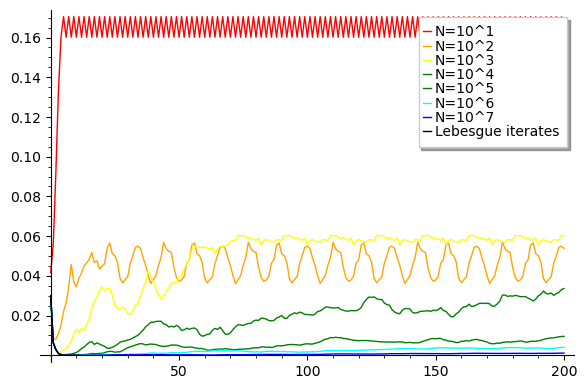

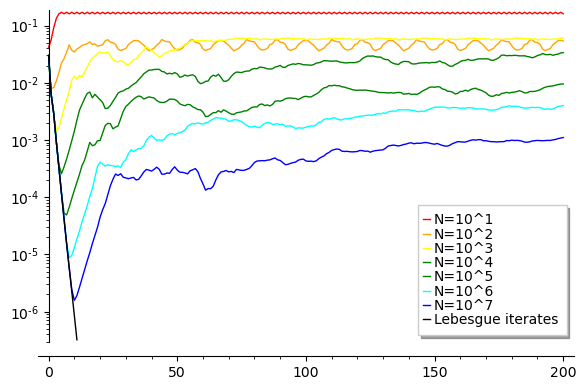

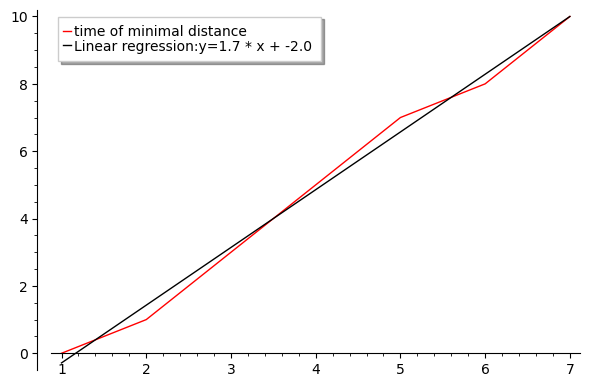

used vars: measure_prec=55913


In [12]:
%%open_vars

# [Cell 13]
# Here distance discr-it to SRB, for several values N up to Tmax

from scipy import stats

Tmax = 200
dist_type = 'DiscrepancyCircle'
discr_type = 'MapToClosest'

N_cols = [
    (10, 'red'), 
    (100, 'orange'),
    (1000, 'yellow'),
    (10000, 'green'),
    (100000, 'green'),
    (1000000, 'cyan'),
    (10000000, 'blue')#,
#    (100000000, 'purple')
]

pl = plot([])
MinPos=[]
for N, col in N_cols:
    distances = build_list(Tmax+1, 
                           (distance_discrit_to_srb(dist_type, discr_type,
                                                    measure_prec, N=N, T=T)
                            for T in range(Tmax+1)),
                           desc=f'N={N}')
    mpos = np.argmin(distances)
    MinPos.append(mpos)
    log_min_dist = math.log(distances[mpos])
    print(f'For N: {N}, min distance at it: {mpos}, log-dist: {log_min_dist}')
    pl += line(list(enumerate(distances)),
                    color = col,
                    legend_label = f'N=10^{int(log(N)/log(10))}')

distaces_to_srb = build_list(Tmax, 
                             (distance_lebit_to_srb(dist_type,
                                                    measure_prec, N=N, T=T)
                            for T in range(Tmax+1)),
                           desc=discr_type)
pl += line(list(enumerate(distaces_to_srb[:12])),
                color = 'black',
                legend_label = f'Lebesgue iterates')

print("\nChart:")
print(f"  distance of discretization `{discr_type}`'s iterates to SRB, for increasing N values (discretized grid size)")
print(f'  T=1,2,...,{Tmax}')
print(f'  N={N} (discretized grid size)')
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
pl.set_legend_options(loc='upper right')
pl.show()
pl.save('Images/DiscrepancySRBN.png',dpi=200)
pl.set_legend_options(loc='lower right')
pl.show(scale='semilogy')
pl.save('Images/DiscrepancySRBNLog.png',dpi=200, scale='semilogy')

Ran=[float(log(N_cols[j][0])/log(10)) for j in range(len(N_cols))]
pl = line([(Ran[j],MinPos[j]) for j in range(len(Ran))], color='red', legend_label='time of minimal distance')

slope, intercept, r, p, std_err = stats.linregress(Ran, MinPos)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, Ran))

pl += line([(Ran[j],mymodel[j]) for j in range(len(Ran))], color='black', 
           legend_label='Linear regression:y='+repr(float(round(10*slope)/10))+' * x + '+repr(float(round(10*intercept)/10)))
pl.show()
pl.save(f"Images/TimeOfMinDist.png",dpi=200)

In [13]:
%%open_vars

# [Cell 14]
# Helpers to work with a set of perturbations, and to print stats of the distances across
# the perturbations (average, standard deviation wrt the perturbation set)

# this helper function show a set of distances with
# their average and +/- standard deviation
def show_perturbed_distances(data_matrix, color, label, aspt = False, showstd = True, showmean=True, showperturb=True):
    data_matrix = np.array(data_matrix)
    
    alpha = 1.0 / (1.0 + data_matrix.shape[0])**0.75
    thickness = 1.5

    pl = plot([])
    plot_func = point if aspt else line
    if showperturb:
        for i in range(data_matrix.shape[0]):
            pl += line(list(enumerate(data_matrix[i,:])),
                        color = color,
                        # legend_label = (discs.__name__ if i==0 else None),
                        thickness=thickness,
                        alpha=alpha)
    pl += line([(0,0.001), (0,0.001)],
               color = color, 
               legend_label = label)

    avg_colors = {"red": "purple"}
    std_colors = {"red": "orange"}
    avg_color = color#avg_colors.get(color, "cyan")
    std_color = color#std_colors.get(color, "lightgreen")
    
    avg = np.average(data_matrix, axis=0)
    std = np.std(data_matrix, axis=0)
    if showmean:
        pl += line(list(enumerate(avg)), #legend_label = "average",
               color = avg_color)
    if showstd:
        pl += line(list(enumerate(avg+std)), # legend_label = "avg +/- std",
                   color = std_color, 
                   linestyle='--')
        pl += line(list(enumerate(avg-std)),
                   color = std_color,linestyle='--')

    pl.set_legend_options(loc='lower right')
    return pl

# we want to plot distance discit_to_lebit for different perturbations
# for clarity we create a class representing a perturbation set
class PerturbationSet:
    def __init__(self, n1 = 5, n2 = 5, n3=1):
        self.n1, self.n2, self.n3 = n1, n2, n3
    
    def desc(self):
        retv = "{Q}*x + {c}*sin({j}*pi*x) + {c2}*sin({j2}*pi*x) + {k}".format(
                Q=D_Q,
                j=D_j,
                c=(D_c if self.n1==1 else "({c}+0.001*p1)".format(c=D_c)),
                j2=D_j2,
                c2=(D_c2 if self.n2==1 else "({c2}+0.001*p2)".format(c2=D_c2)),
                k=(D_k if self.n3==1 else "({k}+0.01*p3)".format(k=D_k)))
        if self.n1 > 1:
            retv += f",\n    for p1=-1,{-1.0 + 2.0  / (self.n1-1)},...,1 ({self.n1} alternatives)"
        if self.n2 > 1:
            retv += f",\n    for p2=-1,{-1.0 + 2.0  / (self.n2-1)},...,1 ({self.n2} alternatives)"
        if self.n3 > 1:
            retv += f",\n    for p3=-1,{-1.0 + 2.0  / (self.n3-1)},...,1 ({self.n3} alternatives)"
        return retv
    
    def num_total(self):
        return self.n1 * self.n2 * self.n3
    
    def pert(self, m):
        p3 = m % self.n3
        n = m // self.n3
        p2 = n % self.n2
        p1 = n // self.n1
        retv = {}
        if self.n1 > 1:
            retv['perturb1'] = float(-1.0 + 2.0 * (p1 / (self.n1-1)))
        if self.n2 > 1:
            retv['perturb2'] = float(-1.0 + 2.0 * (p2 / (self.n2-1)))
        if self.n3 > 1:
            retv['perturb3'] = float(-1.0 + 2.0 * (p3 / (self.n3-1)))
        return retv


(no used vars)


perturbated iterations:   0%|          | 0/775 [00:00<?, ?it/s]


Chart:
  distance of discretization MapToClosest's iterate from Lebesgue iterate
  system: x |-> 2*x + (0.0393275800000000+0.001*p1)*sin(4*pi*x) + (0.0531647000000000+0.001*p2)*sin(2*pi*x) + 0.347000000000000,
    for p1=-1,-0.5,...,1 (5 alternatives),
    for p2=-1,-0.5,...,1 (5 alternatives)
  T=1,2,...,30
  N=25000 (discretized grid size)
  measure_prec=55913 (order of Perron operator, precision of measures)


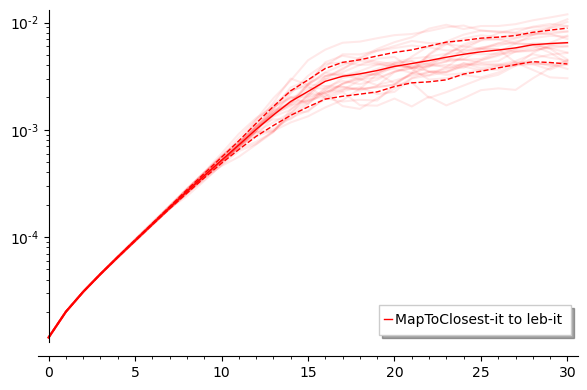

used vars: discr_type=MapToClosest, measure_prec=55913


In [14]:
%%open_vars

# [Cell 15]
# Simple test

Tmax = 30
N = 25000
perturbs = PerturbationSet(5, 5)

all_distances = build_list(perturbs.num_total() * (Tmax+1), 
                           (distance_discrit_to_lebit(dist_type,
                                    discr_type, measure_prec, N=N, T=T,
                                    **perturbs.pert(p))
                            for p in range(perturbs.num_total())
                            for T in range(Tmax+1)),
                           group_by=Tmax+1,
                           desc=f'perturbated iterations')

pl = show_perturbed_distances(all_distances,
                              "red", #get_discretization(discr_type).color,
                              discr_type+'-it to leb-it')

print("\nChart:")
print(f"  distance of discretization {discr_type}'s iterate from Lebesgue iterate")
print(f"  system: x |-> {perturbs.desc()}")
print(f'  T=1,2,...,{Tmax}')
print(f'  N={N} (discretized grid size)')
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
pl.show(scale='semilogy')


computing on grid size N=1024, j=0


perturbated iterations:   0%|          | 0/775 [00:00<?, ?it/s]


Chart:
  distance of discretization MapToClosest's iterate from Lebesgue iterate
  system: x |-> 2*x + (0.0393275800000000+0.001*p1)*sin(4*pi*x) + (0.0531647000000000+0.001*p2)*sin(2*pi*x) + 0.347000000000000,
    for p1=-1,-0.5,...,1 (5 alternatives),
    for p2=-1,-0.5,...,1 (5 alternatives)
  T=1,2,...,30
  N=1024 (discretized grid size)
  measure_prec=55913 (order of Perron operator, precision of measures)


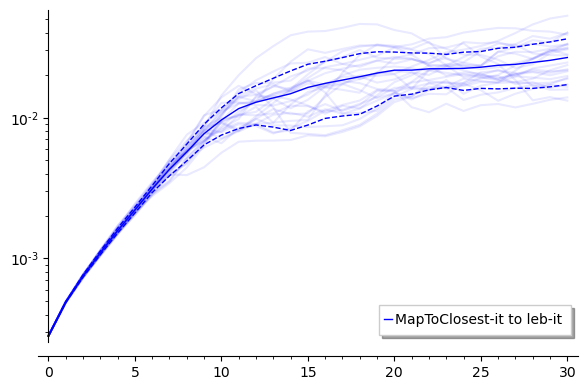


computing on grid size N=5792, j=10


perturbated iterations:   0%|          | 0/775 [00:00<?, ?it/s]


Chart:
  distance of discretization MapToClosest's iterate from Lebesgue iterate
  system: x |-> 2*x + (0.0393275800000000+0.001*p1)*sin(4*pi*x) + (0.0531647000000000+0.001*p2)*sin(2*pi*x) + 0.347000000000000,
    for p1=-1,-0.5,...,1 (5 alternatives),
    for p2=-1,-0.5,...,1 (5 alternatives)
  T=1,2,...,30
  N=5792 (discretized grid size)
  measure_prec=55913 (order of Perron operator, precision of measures)


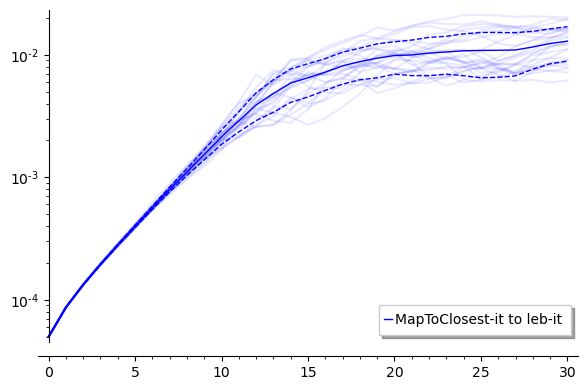


computing on grid size N=32768, j=20


perturbated iterations:   0%|          | 0/775 [00:00<?, ?it/s]


Chart:
  distance of discretization MapToClosest's iterate from Lebesgue iterate
  system: x |-> 2*x + (0.0393275800000000+0.001*p1)*sin(4*pi*x) + (0.0531647000000000+0.001*p2)*sin(2*pi*x) + 0.347000000000000,
    for p1=-1,-0.5,...,1 (5 alternatives),
    for p2=-1,-0.5,...,1 (5 alternatives)
  T=1,2,...,30
  N=32768 (discretized grid size)
  measure_prec=55913 (order of Perron operator, precision of measures)


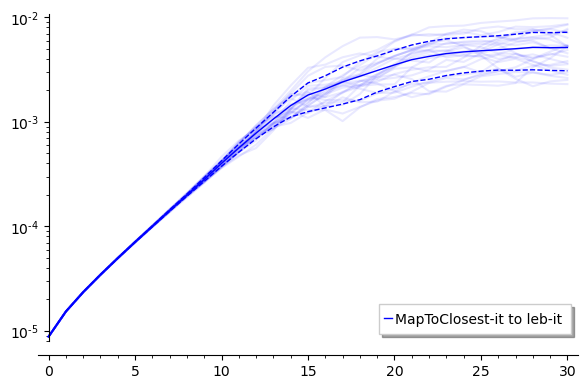


computing on grid size N=185363, j=30


perturbated iterations:   0%|          | 0/775 [00:00<?, ?it/s]


Chart:
  distance of discretization MapToClosest's iterate from Lebesgue iterate
  system: x |-> 2*x + (0.0393275800000000+0.001*p1)*sin(4*pi*x) + (0.0531647000000000+0.001*p2)*sin(2*pi*x) + 0.347000000000000,
    for p1=-1,-0.5,...,1 (5 alternatives),
    for p2=-1,-0.5,...,1 (5 alternatives)
  T=1,2,...,30
  N=185363 (discretized grid size)
  measure_prec=55913 (order of Perron operator, precision of measures)


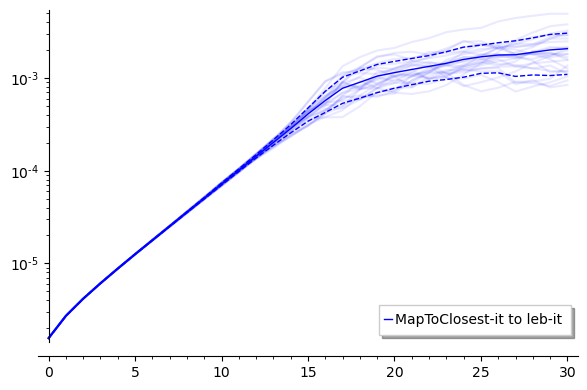

used vars: perturbs=<__main__.PerturbationSet object at 0x7efe4411f0d0>, Tmax=30, discr_type=MapToClosest, measure_prec=55913


In [15]:
%%open_vars

# [Cell 16]
# Show stats of perturbed distances (discr-it to leb-it) for
# and exponentially increasing set of N values, T up to Tmax

for j in range(0, 40, 10):
    N=int(sqrt(sqrt(2))**(40+j))
    print(f"\ncomputing on grid size N={N}, j={j}")

    all_distances = build_list(perturbs.num_total()*(Tmax+1), 
                               (distance_discrit_to_lebit(dist_type,
                                        discr_type, measure_prec, N=N, T=T,
                                        **perturbs.pert(p))
                                for p in range(perturbs.num_total())
                                for T in range(Tmax+1)),
                               group_by=Tmax+1,
                               desc=f'perturbated iterations')

    pl = show_perturbed_distances(all_distances,
                                  get_discretization(discr_type).color,
                                  discr_type+'-it to leb-it')
    
    print("\nChart:")
    print(f"  distance of discretization {discr_type}'s iterate from Lebesgue iterate")
    print(f"  system: x |-> {perturbs.desc()}")
    print(f'  T=1,2,...,{Tmax}')
    print(f'  N={N} (discretized grid size)')
    print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
    pl.show(scale='semilogy')
    pl.save(f"Images/DiscrepancySRBPerturb{N}.png",dpi=200, scale='semilogy')

In [16]:
%%open_vars

# [Cell 17]
# Utilities to predict the discrepancies, compute the derivative
# values of iterates.

# computes the prediction for the discrepancy for discretizations
from discr_utils import *

# helper, computes derivative and point-image of an iterate
@memodb
def compute_derivatives_and_ptimg(measure_prec, t, **kwargs):
    if t == 0:
        derivatives = np.ones(measure_prec)
        pts = np.array([(i+float(0.5))/measure_prec
                        for i in range(measure_prec)])
        return derivatives, pts
    else:
        derivatives, pts = compute_derivatives_and_ptimg(measure_prec,
                                                         t-1, **kwargs)
        D = perturbed_system(**kwargs)
        new_ders = np.array([ derivatives[i] * D.quick_fprime(pts[i])
                              for i in range(measure_prec) ])
        new_pts = np.array([D.quick_f(pt) for pt in pts])
        return new_ders, new_pts

# compute the predicted distance of a discretized iterate to leb-it
@memodb
def compute_predicted_distance(measure_prec, k, **kwargs):
    tot = 0
    for m in range(0,k):#ranging the sum
        deriv, pts = compute_derivatives_and_ptimg(measure_prec, k-m, **kwargs)
        w = lebesgue_iterate(measure_prec, k, **kwargs)
        tot += np.dot(deriv, w)

    return 1/12 + tot/12


(no used vars)



Chart:
  distance of discretization `MapToClosest`'s iterates to SRB
  overlayed to prediction for small values according to formula XXX
  T=1,2,...,21
  N=25000 (discretized grid size)
  measure_prec=55913 (order of Perron operator, precision of measures)


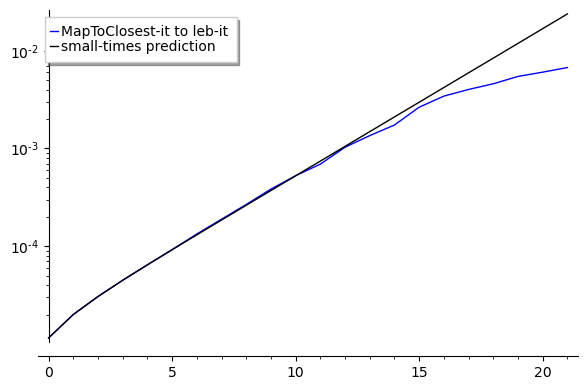

used vars: discr_type=MapToClosest, measure_prec=55913


In [17]:
%%open_vars

# [Cell 18]
# Show distance (discr-it to leb-it) overlaid to the prediction
N = 25000
Tmax = 21
distances = [distance_discrit_to_lebit(dist_type, discr_type,
                                       measure_prec, N=N, T=T)
             for T in range(Tmax+1)]
pl = list_plot(distances, color = get_discretization(discr_type).color, plotjoined=True,
               legend_label = f'{discr_type}-it to leb-it')

pred = [compute_predicted_distance(measure_prec, t) for t in range(Tmax+1)]

pl += line(list(enumerate([sqrt(x)/N for x in pred])), legend_label='small-times prediction', color='black')

print("\nChart:")
print(f"  distance of discretization `{discr_type}`'s iterates to SRB")
print(f"  overlayed to prediction for small values according to formula XXX")
print(f'  T=1,2,...,{Tmax}')
print(f'  N={N} (discretized grid size)')
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
pl.show(scale="semilogy")

perturbed iterations:   0%|          | 0/775 [00:00<?, ?it/s]


Chart:
  distance of discretization MapToClosest's iterate from Lebesgue iterate
  system: x |-> 2*x + (0.0393275800000000+0.001*p1)*sin(4*pi*x) + (0.0531647000000000+0.001*p2)*sin(2*pi*x) + 0.347000000000000,
    for p1=-1,-0.5,...,1 (5 alternatives),
    for p2=-1,-0.5,...,1 (5 alternatives)
  overlay: small-times prediction for un-perturbed system
  T=1,2,...,30
  N=2000000 (discretized grid size)
  measure_prec=32768 (order of Perron operator, precision of measures)
  12N²prediction[0]²=0.9999999999999998 


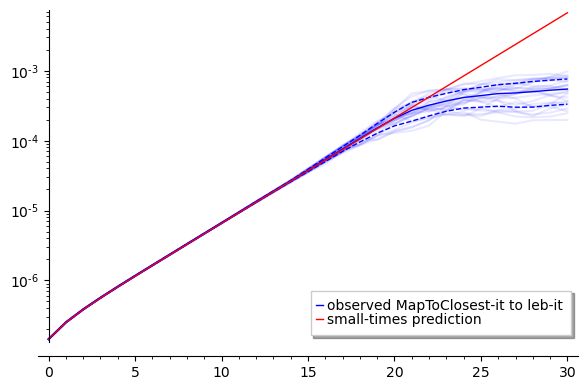


Chart:


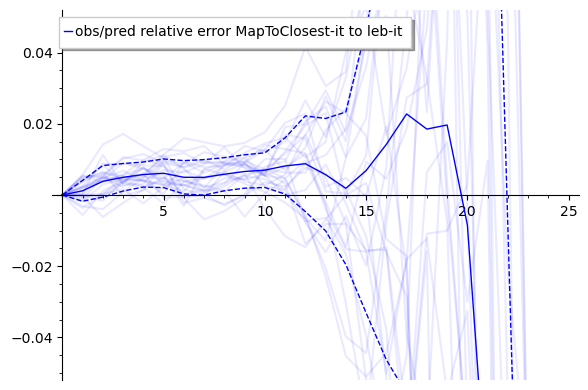

used vars: perturbs=<__main__.PerturbationSet object at 0x7efe4411f0d0>


In [18]:
%%open_vars

# Two graphics
# The first one shows with log scale the discrepancies depending on time for various perturbations, as well as the prediction for it
# The second one shows the relative difference between the actual discrepancies and the prediction
# !!! if measure_prec resonates with N, the results can be misleading !!!

discr_type = 'MapToClosest'
measure_prec=32768

N=2000000
Tmax=30

all_distances = build_list(perturbs.num_total() * (Tmax+1), 
                           (distance_discrit_to_lebit(dist_type,
                                    discr_type, measure_prec, N=N, T=T,
                                    **perturbs.pert(p))
                            for p in range(perturbs.num_total())
                            for T in range(Tmax+1)),
                           group_by=Tmax+1,
                           desc=f'perturbed iterations')

pl = show_perturbed_distances(all_distances,
                              get_discretization(discr_type).color,
                              f'observed {discr_type}-it to leb-it')

prediction = np.array([float(sqrt(compute_predicted_distance(measure_prec, t))/N) for t in range(Tmax+1)])

pl += line(list(enumerate(prediction)), color='red', legend_label='small-times prediction')

print("\nChart:")
print(f"  distance of discretization {discr_type}'s iterate from Lebesgue iterate")
print(f"  system: x |-> {perturbs.desc()}")
print(f"  overlay: small-times prediction for un-perturbed system")
print(f'  T=1,2,...,{Tmax}')
print(f'  N={N} (discretized grid size)')
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")

print(f'  12N²prediction[0]²={prediction[0]**2*12*N**2} ')
pl.show(scale='semilogy')
pl.save(f"Images/DiscrepancySRBWPred.png",dpi=200, scale='semilogy')

all_relative_errors = [(d - prediction) / prediction for d in all_distances]

pl = show_perturbed_distances(all_relative_errors,
                              get_discretization(discr_type).color,
                              f'obs/pred relative error {discr_type}-it to leb-it')
pl.save(f"Images/DiscrepancySRBBcp.png",dpi=200)

pl.set_legend_options(loc='upper left')
print("\nChart:")
pl.show(ymin=-0.05, ymax=0.05, xmax=25)
pl.save(f"Images/DiscrepancySRBRelDiff.png",dpi=200)

  i=10 (discretized grid size N=2^i)


perturbed iterations:   0%|          | 0/525 [00:00<?, ?it/s]

  j=5
----------------

Chart:


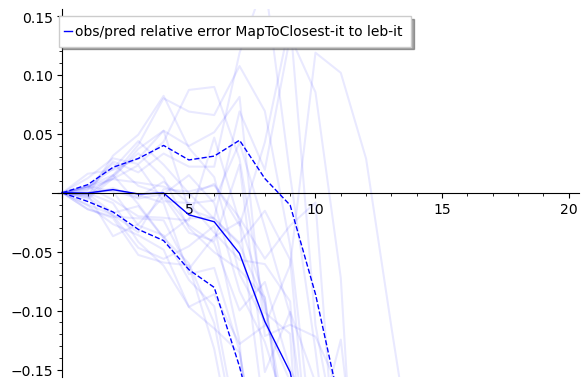

  i=11 (discretized grid size N=2^i)


perturbed iterations:   0%|          | 0/525 [00:00<?, ?it/s]

  j=5
----------------

Chart:


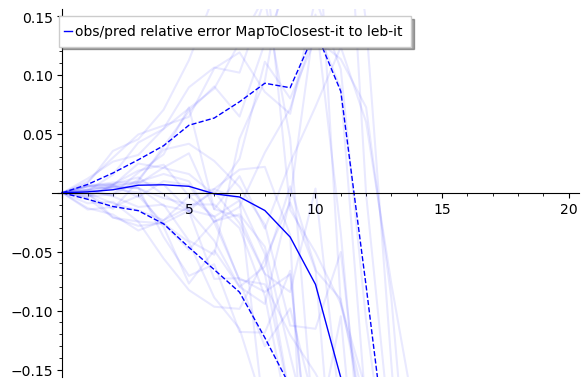

  i=12 (discretized grid size N=2^i)


perturbed iterations:   0%|          | 0/525 [00:00<?, ?it/s]

  j=6
----------------

Chart:


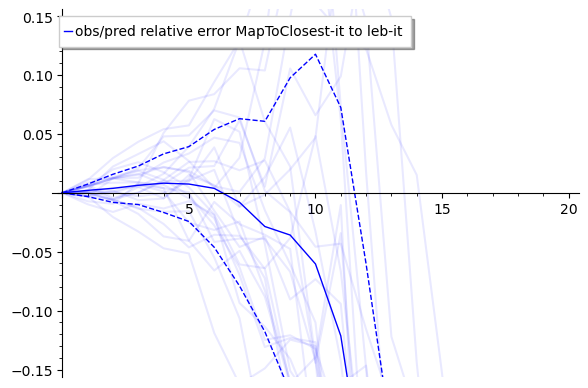

  i=13 (discretized grid size N=2^i)


perturbed iterations:   0%|          | 0/525 [00:00<?, ?it/s]

  j=7
----------------

Chart:


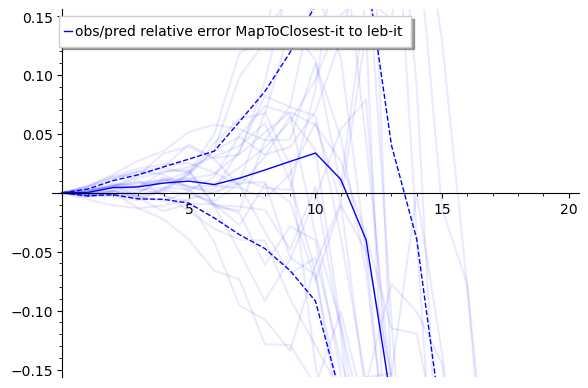

  i=14 (discretized grid size N=2^i)


perturbed iterations:   0%|          | 0/525 [00:00<?, ?it/s]

  j=9
----------------

Chart:


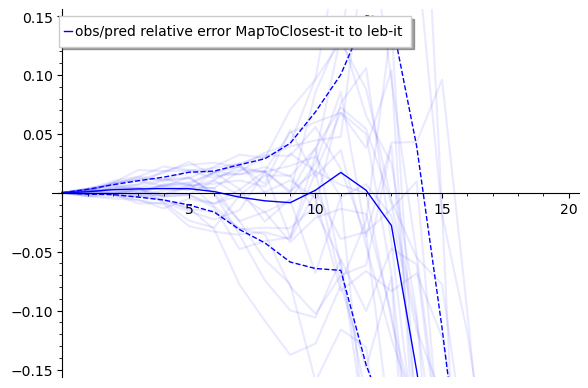

  i=15 (discretized grid size N=2^i)


perturbed iterations:   0%|          | 0/525 [00:00<?, ?it/s]

  j=10
----------------

Chart:


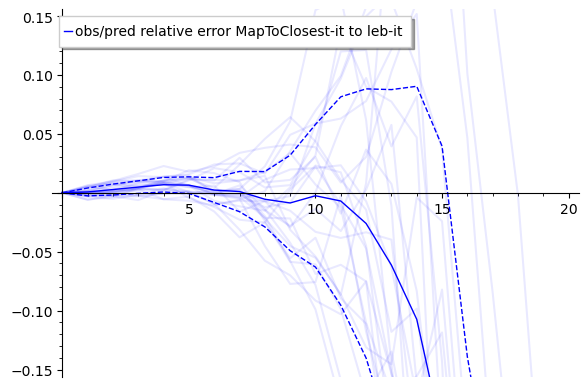

  i=16 (discretized grid size N=2^i)


perturbed iterations:   0%|          | 0/525 [00:00<?, ?it/s]

  j=10
----------------

Chart:


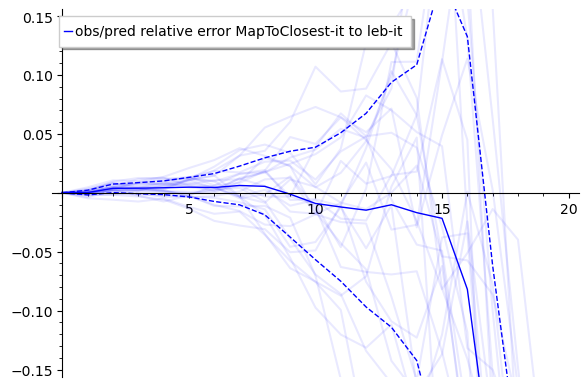

  i=17 (discretized grid size N=2^i)


perturbed iterations:   0%|          | 0/525 [00:00<?, ?it/s]

  j=11
----------------

Chart:


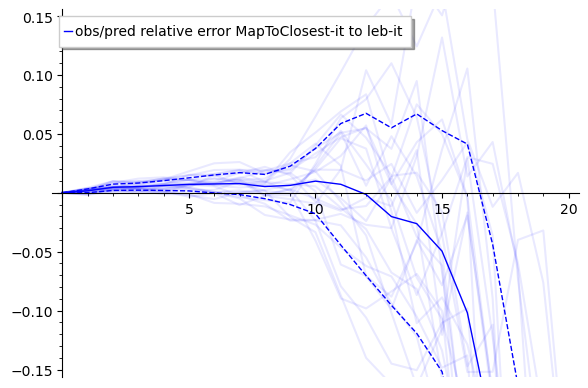

  i=18 (discretized grid size N=2^i)


perturbed iterations:   0%|          | 0/525 [00:00<?, ?it/s]

  j=13
----------------

Chart:


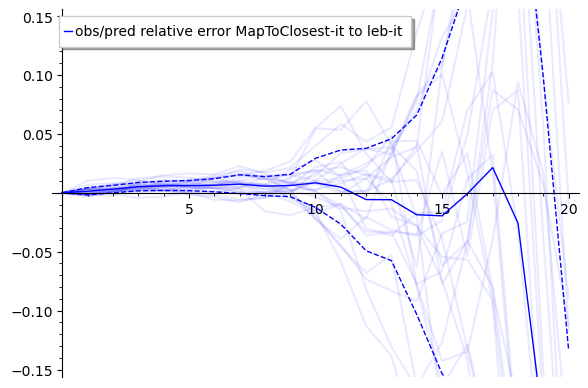

  i=19 (discretized grid size N=2^i)


perturbed iterations:   0%|          | 0/525 [00:00<?, ?it/s]

  j=13
----------------

Chart:


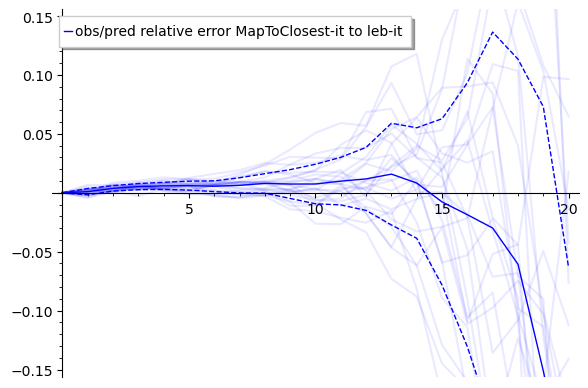

  i=20 (discretized grid size N=2^i)


perturbed iterations:   0%|          | 0/525 [00:00<?, ?it/s]

  j=14
----------------

Chart:


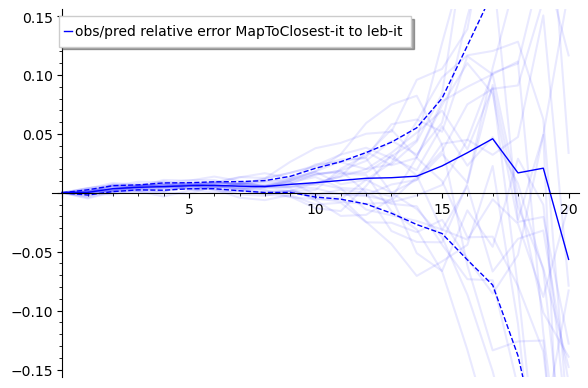

  i=21 (discretized grid size N=2^i)


perturbed iterations:   0%|          | 0/525 [00:00<?, ?it/s]

  j=16
----------------

Chart:


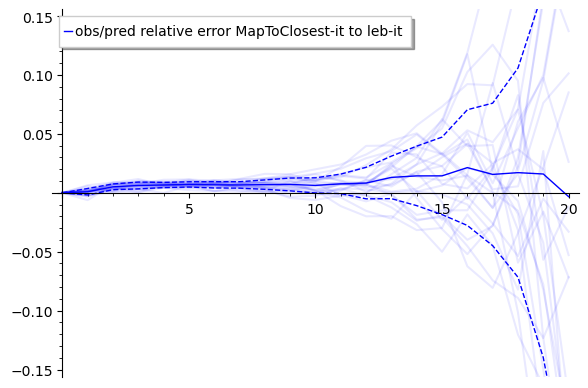

  i=22 (discretized grid size N=2^i)


perturbed iterations:   0%|          | 0/525 [00:00<?, ?it/s]

  j=17
----------------

Chart:


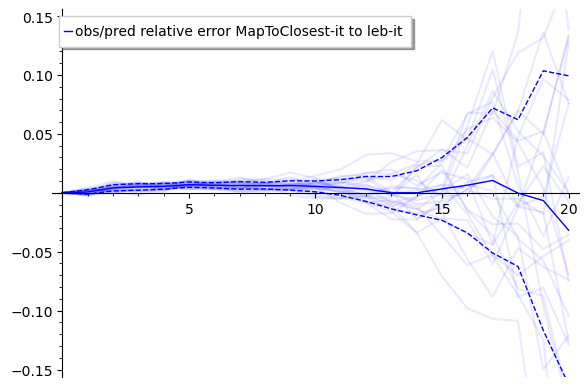

  i=23 (discretized grid size N=2^i)


perturbed iterations:   0%|          | 0/525 [00:00<?, ?it/s]

  j=19
----------------

Chart:


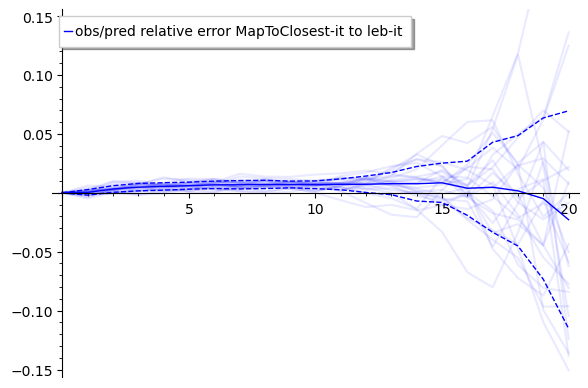

  i=24 (discretized grid size N=2^i)


perturbed iterations:   0%|          | 0/525 [00:00<?, ?it/s]

  j=19
----------------

Chart:


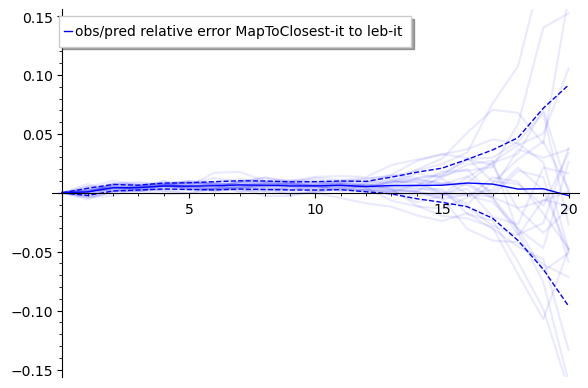

[ 5.  5.  6.  7.  9. 10. 10. 11. 13. 13. 14. 16. 17. 19. 19.]


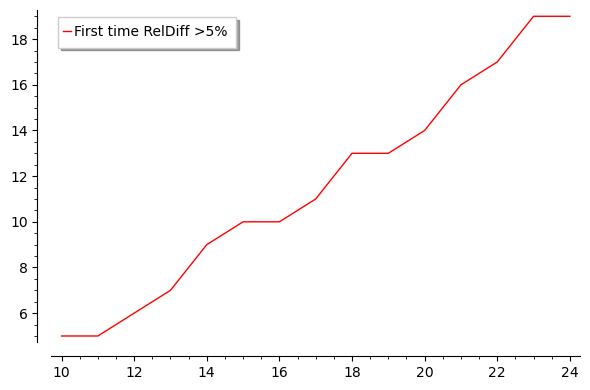

used vars: perturbs=<__main__.PerturbationSet object at 0x7efe4411f0d0>


In [19]:
%%open_vars

# Two graphics
# The first one shows the relative difference between the actual discrepancies and the prediction
# The second one shows the first time the relative diffrernce with the prediction +/-std is >5% depending on the size of perturbation
measure_prec = 11*13*17*23
discr_type = 'MapToClosest'

Tmax=20
Ran=range(10,25)
TRelev=np.zeros(len(Ran))

for i in Ran:
    N=int(2**i)
    print(f'  i={i} (discretized grid size N=2^i)')
    all_distances = build_list(perturbs.num_total() * (Tmax+1), 
                               (distance_discrit_to_lebit(dist_type,
                                        discr_type, measure_prec, N=N, T=T,
                                        **perturbs.pert(p))
                                for p in range(perturbs.num_total())
                                for T in range(Tmax+1)),
                               group_by=Tmax+1,
                               desc=f'perturbed iterations')

    #pl = show_perturbed_distances(all_distances, get_discretization(discr_type).color, f'observed {discr_type}-it to leb-it')

    prediction = np.array([float(sqrt(compute_predicted_distance(measure_prec, t))/N) for t in range(Tmax+1)])
    #pl += line(list(enumerate(prediction)), color='red', legend_label='small-times prediction')
 
    #pl.show(scale='semilogy')
    #pl.save(f"Images/DiscrepancySRBWPred.png",dpi=200, scale='semilogy')

    all_relative_errors = [(d - prediction) / prediction for d in all_distances]
    
    j=0
    avg = np.average(all_relative_errors, axis=0)
    std = np.std(all_relative_errors, axis=0)
    pl=line(list(enumerate(avg)))
    #pl.show()
    while avg[j]+std[j]<0.05 and avg[j]-std[j]>-0.05 and j<Tmax:
        j+=1
    TRelev[i-Ran[0]]=j
    print(f'  j={j}')
    print(f'----------------')
    pl = show_perturbed_distances(all_relative_errors,get_discretization(discr_type).color,f'obs/pred relative error {discr_type}-it to leb-it')

    pl.set_legend_options(loc='upper left')
    print("\nChart:")
    pl.show(ymin=-0.15, ymax=0.15)
    pl.save(f"Images/DiscrepancySRBRelDiff{i}.png",dpi=200)
    pl = line([(Ran[i],TRelev[i]) for i in range(len(TRelev))], color='red', legend_label='First time RelDiff >5%')
    pl.save(f"Images/DiscrepancySRBRelDiff5percent.png",dpi=200)
print(TRelev)
pl.show()

In [20]:
%%open_vars

# these functions compute the expected discrepancy and sigma,
# etc from a given measure to N random points according to
# the measure itself

# E(Disc^2)
def EDiscrepancy2_RandomPoints(meas):
    cdf = np.cumsum(meas)
    cdf = cdf - np.average(cdf) #f
    F = np.cumsum(cdf) / len(cdf)
    intf2 = np.average(cdf**2)
    intF = np.average(F)
    return -intf2 - 2*intF

# returns E(Disc^4), for N points will need to multiply by (N-1)/N^3 ~ 1/N^2
def EDiscrepancy4_RandomPoints(meas):
    fprime = meas * len(meas)
    f = np.cumsum(meas)
    f = f - np.average(f)
    F = np.cumsum(f) / len(f)
    intf2 = np.average(cdf**2)
    intF = np.average(F)
    I1a = (-intf2 - 2*intF)
    I1 = 3*I1a*I1a
    I2 = -2*np.average(F**2 * fprime)
    a = (np.arange(len(f))+0.5) / len(f)
    I3 = 2*np.average((a - a**2) * f**2)
    I4 = 4*np.square(np.average(F))
    I5 = -4*np.average(F**2)
    return sum([I1, I2, I3, I4, I5])

# returns the standard deviation of Disc^2
def ESigma_Discrepancy2_NRandomPoints(meas, N):
    d2 = EDiscrepancy2_RandomPoints(meas)
    d4 = EDiscrepancy4_RandomPoints(meas)
    sigma = sqrt(d4 - d2**2)
    return d2/N, sigma/N

(no used vars)


In [21]:
%%open_vars

# computes the density of survivor (non-empty!) grid points
# ASSUMES number of branches equals 2
def NextSurvivorsDensityDeg2(density, P, Dprime):
    Lf_density = P * density
    return Lf_density - ((Lf_density**2) - P*((density**2) / Dprime)) / 2.0

# like above, but furthermore compute density of mult1
#   new_m1(x) = \sum m1(y)/f'(y) * \prod_{z\neq y} (1-\frac{delta(z)}{f'(z)})
# and for the case of two branches it becomes
#   L_f(m1) - L_f(m1)*L_f(delta) + L_f(\frac{m1 * delta}{f'})
# ASSUMES number of branches equals 2
def NextSurvivorsDensityMult1Deg2(density, mult1, P, Dprime):
    Lf_density = P * density
    new_density = Lf_density - (Lf_density**2 - P*(density**2 / Dprime)) / 2
    Lf_mult1 = P * mult1
    new_mult1 = Lf_mult1 - (Lf_mult1*Lf_density) + P*(mult1 * density / Dprime)
    return new_density, new_mult1

@memodb
def density_surv_mult1(measure_prec: Int, T: Int, **kwargs):
    if T == 0:
        return (np.ones(measure_prec), np.zeros(measure_prec))
    else:
        deriv, _ = compute_derivatives_and_ptimg(measure_prec, 1, **kwargs)
        P, _ = system_perron_srb(measure_prec, **kwargs)
        prev_dsurv, prev_mult1 = density_surv_mult1(measure_prec, T-1, **kwargs)
        return NextSurvivorsDensityMult1Deg2(prev_dsurv, prev_mult1, P, deriv)

def edisc_survivor_density_to_random_pts(measure_prec: Int, T: Int, N: Int, **kwargs):
    dsurv, dmult1 = density_surv_mult1(measure_prec, T, **kwargs)
    meas_surv = dsurv / sum(dsurv)
    expectedN = N * sum(dsurv) / measure_prec
    return sqrt(EDiscrepancy2_RandomPoints(meas_surv) / expectedN)

def edisc_lebit_to_predicted_num_of_random_pts(measure_prec: Int, T: Int, N: Int, **kwargs):
    dsurv, dmult1 = density_surv_mult1(measure_prec, T, **kwargs)
    expectedN = N * sum(dsurv) / measure_prec
    lebit = lebesgue_iterate(measure_prec, T, **kwargs)
    return sqrt(EDiscrepancy2_RandomPoints(lebit) / expectedN)


(no used vars)


disc-it to leb-it:   0%|          | 0/42 [00:00<?, ?it/s]

prediction with surv_density:   0%|          | 0/42 [00:00<?, ?it/s]

prediction with lebit:   0%|          | 0/42 [00:00<?, ?it/s]

  distance of discretization `MapToClosest`'s iterates to SRB
  overlayed: iterating the density of non-empty grid points, expected discrepancy
    of M random points (the expected # of non-empty grids points) from such density)
  T=1,2,...,41
  N=25000 (discretized grid size)
  measure_prec=55913 (order of Perron operator, precision of measures)


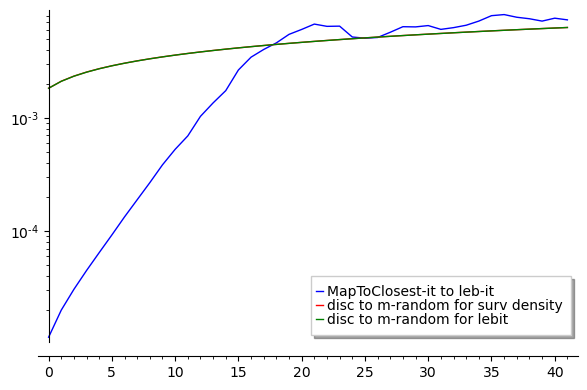

distances with surv (20-24): [0.004642910422525821, 0.004734699018534076, 0.004824602097935234, 0.004912733872039078, 0.004999197335702018]
distances with lebit (20-24): [0.004640627149519346, 0.004732466587838103, 0.004822417181086204, 0.004910593492810687, 0.004997098819703031]
used vars: discr_type=MapToClosest, measure_prec=55913


In [22]:
%%open_vars

N = 25000
Tmax = 41

distances = build_list(Tmax+1,
                       (distance_discrit_to_lebit(dist_type, discr_type,
                                       measure_prec, N=N, T=T)
                        for T in range(Tmax+1)),
                        desc=f'disc-it to leb-it')
pl = list_plot(distances, color = get_discretization(discr_type).color,
               plotjoined=True,
               legend_label = f'{discr_type}-it to leb-it')

distancesSurv = build_list(Tmax+1, 
                       (edisc_survivor_density_to_random_pts(measure_prec, T, N)
                        for T in range(Tmax+1)),
                        desc=f'prediction with surv_density')
pl += line(list(enumerate(distancesSurv)),
                color = "red",
                legend_label = f'disc to m-random for surv density')

distancesLebit = build_list(Tmax+1, 
                       (edisc_lebit_to_predicted_num_of_random_pts(measure_prec, T, N)
                        for T in range(Tmax+1)),
                        desc=f'prediction with lebit')
pl += line(list(enumerate(distancesLebit)),
                color = "green", 
                legend_label = f'disc to m-random for lebit')

print(f"  distance of discretization `{discr_type}`'s iterates to SRB")
print(f"  overlayed: iterating the density of non-empty grid points, expected discrepancy")
print(f"    of M random points (the expected # of non-empty grids points) from such density)")
print(f'  T=1,2,...,{Tmax}')
print(f'  N={N} (discretized grid size)')
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
pl.show(scale="semilogy")

print('distances with surv (20-24):', distancesSurv[20:25])
print('distances with lebit (20-24):', distancesLebit[20:25])

In [23]:
%%open_vars

# executed a multiplication of "polynomials" possibly modulo 
# x^(l+1) - x^l (all higher order coefficients are absorbed into x^l)
def polyMult(P1, P2, limitDeg=None):
    l1, l2 = len(P1), len(P2)
    rlen = l1+l2-1
    if limitDeg is not None:
        rlen = min(rlen, limitDeg+1)
    retv = [
        sum(P1[j] * P2[i-j] for j in range(max(0, i-l2+1), min(i+1, l1)))
        for i in range(rlen)
    ]
    if (limitDeg is not None) and (l1+l2-1 > limitDeg+1):
        for i in range(rlen, l1+l2-1):
            retv[limitDeg] += sum(P1[j] * P2[i-j] for j in range(max(0, i-l2+1), min(i+1, l1)))

    return retv

# coefficientwise apply M to coefficients
def transformAll(M, Poly):
    return [M*p for p in Poly]

# addition of "polynomials"
def polyAdd(P1, P2):
    retv = [p1i + p2i for p1i, p2i in zip(P1, P2)] + (
            P1[len(P2):] if len(P1)>len(P2) else P2[len(P1):]
        )
    return retv

# P[i] is the density of points with i-preimages
def iterateDensMultiplicities(Perron, Q, Dprime, nBranches, limitDeg=None):
    
    # this computes the "power sums" surrogate:
    #   (-1)^{i-1} p_i = Perron((-1)^{i-1} * Q^i / Df^{i-1})
    # we have to compute only up to d (the degree of the system)
    Psums = [transformAll(Perron, Q)] # power sums, with signs
    mQdivDf = [-Qi / Dprime for Qi in Q] # - Q/(f')
    prevF = Q
    for i in range(1, nBranches):
        prevF = polyMult(prevF, mQdivDf, limitDeg=limitDeg)
        Psums.append(transformAll(Perron, prevF))

    # apply Newton formula to compute e_i from p_i, the formula is:
    # k * e_k = e_{k-1}*p_1 - e_{k-2}*p_2 + ... + (-1)^{k-2}e_1*p_{k-1} + (-1)^{k-1}p_k
    Esimm = [Psums[0]]
    Retv = Psums[0]
    for i in range(1, nBranches):
        X = Psums[i]
        for j in range(i):
            X = polyAdd(X, polyMult(Esimm[i-j-1], Psums[j], limitDeg=limitDeg))
        X = [Xi/(i+1.0) for Xi in X]
        Esimm.append(X)
        Retv = polyAdd(Retv, X)

    return Retv

# print a surrogate polynomial (coefficients being functions)
def polyPrint(Q, limitDeg=None, plus1=True, alpha=1.0, pl=None, show=True, labels=True):
    if pl==None:
        pl=plot([])
    cols = { 0: 'red', 1: 'purple', 2: 'blue', 3:'cyan', 4: 'green', 5: 'yellow', 6: 'orange' }
    cols[limitDeg] = 'brown'

    for i in range(len(Q)):
        lab = (None if (not labels or i not in cols)
                else 'PreImg={}{}'.format(i, '+' if i==limitDeg else ''))
        plotFunc = (Q[i]+1) if plus1 and i==0 else Q[i]
        size = len(plotFunc)
        pl += line([((i+0.5)/size, x) for i,x in enumerate(plotFunc)],
                   color=cols.get(i, 'grey'),
                   legend_label=lab,
                   alpha=alpha)
    if show:
        pl.set_legend_options(loc='upper right')
        pl.show(ymin=0, ymax=1.0) #scale='semilogy')
    return pl

@memodb
def predictedDensMultiplicities(measure_prec, T, nBranches, limitDeg=8, **kwargs):
    
    if T == 0:
        one = np.array([1.0 for _ in range(measure_prec)])
        return [-one, one]
    else:
        Q = predictedDensMultiplicities(measure_prec, T-1, nBranches, limitDeg=limitDeg, **kwargs)
        deriv, _ = compute_derivatives_and_ptimg(measure_prec, 1, **kwargs)
        Perron, _ = system_perron_srb(measure_prec, **kwargs)
        return iterateDensMultiplicities(Perron, Q, deriv, nBranches, limitDeg=limitDeg)


(no used vars)


observed, perturbed iteration:   0%|          | 0/2525 [00:00<?, ?it/s]

prediction, perturbed iteration:   0%|          | 0/2525 [00:00<?, ?it/s]

predicted multiplicity densities:   0%|          | 0/100 [00:00<?, ?it/s]


Chart:
  distance of discretization {}'s iterate from Lebesgue iterate, for all perturbations
  overlayed: iterating the density of non-empty grid points, expected discrepancy
    of M random points (the expected # of non-empty grids points) from such density)
  system: x |-> 2*x + (0.0393275800000000+0.001*p1)*sin(4*pi*x) + (0.0531647000000000+0.001*p2)*sin(2*pi*x) + 0.347000000000000,
    for p1=-1,-0.5,...,1 (5 alternatives),
    for p2=-1,-0.5,...,1 (5 alternatives)
  T=1,2,...,100
  N=50000 (discretized grid size)
  measure_prec=55913 (order of Perron operator, precision of measures)


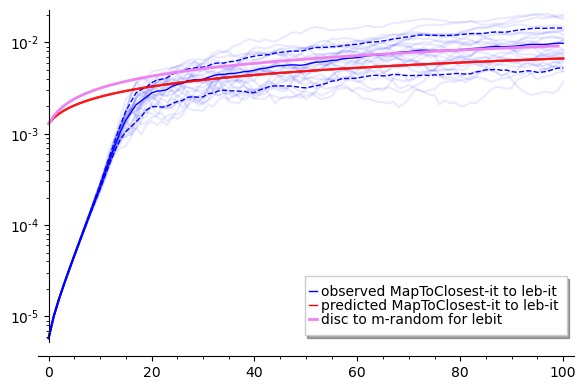

used vars: perturbs=<__main__.PerturbationSet object at 0x7efe4411f0d0>, measure_prec=55913


In [24]:
%%open_vars

N = 50000
Tmax = 100
discr_type = 'MapToClosest'

# empiric distances
all_observed_distances = build_list(perturbs.num_total()*(Tmax+1), 
                           (distance_discrit_to_lebit(dist_type,
                                    discr_type, measure_prec, N=N, T=T,
                                    **perturbs.pert(p))
                            for p in range(perturbs.num_total())
                            for T in range(Tmax+1)),
                           group_by=Tmax+1,
                           desc=f'observed, perturbed iteration')

# predicted distances, as EDisc2 of random points according to Leb iterate
all_predicted_distances = build_list(perturbs.num_total()*(Tmax+1), 
                           (edisc_survivor_density_to_random_pts(
                               measure_prec, T, N, **perturbs.pert(p))
                            for p in range(perturbs.num_total())
                            for T in range(Tmax+1)),
                           group_by=Tmax+1,
                           desc=f'prediction, perturbed iteration')

pl = show_perturbed_distances(all_observed_distances,
                              get_discretization(discr_type).color,
                              f'observed {discr_type}-it to leb-it')

pl += show_perturbed_distances(all_predicted_distances,
                               'red', #get_discretization(discr_type).color,
                               f'predicted {discr_type}-it to leb-it', showstd=False, showmean=False)

dist = get_discrete_distance(dist_type = 'DiscrepancyCircle')
numIts = Tmax
Qs = build_list(numIts,
                (predictedDensMultiplicities(measure_prec, T=t, nBranches=2, limitDeg=256)
                 for t in range(numIts)),
                desc="predicted multiplicity densities")

expected_dist_list=np.zeros(numIts)
for t in range(numIts):
    expected_dist=0
    for m in range(len(Qs[t])):
        meas=Qs[t][m]/sum(Qs[t][m]) - np.ones(measure_prec)/measure_prec
        expected_dist+=sum(Qs[t][m])*(1/12 - dist(meas)^2)*m**2
    expected_dist_list[t]=sqrt(expected_dist/measure_prec/N)

pl += line(list(enumerate(expected_dist_list)),
                color = "violet", 
                thickness=2,
                legend_label = f'disc to m-random for lebit')

print("\nChart:")
print("  distance of discretization {}'s iterate from Lebesgue iterate, for all perturbations")
print(f"  overlayed: iterating the density of non-empty grid points, expected discrepancy")
print(f"    of M random points (the expected # of non-empty grids points) from such density)")
print(f"  system: x |-> {perturbs.desc()}")
print(f'  T=1,2,...,{Tmax}')
print(f'  N={N} (discretized grid size)')
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
pl.show(scale='semilogy')
pl.save('SavePink.png',dpi=200, scale='semilogy')

In [ ]:
%%open_vars

##################################
# The following graph displays the distance between the discrete measures and the iterates of Lebesgue measure under the transfer operator measure 
# depending on time, for different types of discretizations


Tmax = 500
dist_type = 'DiscrepancyCircle'
pl = plot([])
N = 100000
perturbs = PerturbationSet(5, 5)
discretizations = [
    'OnceDecidedRandom',
    'MapToCombination',
    'MapToClosest',
    'StepwiseRandom',
    'PointsRandomOnGrid',
    'PointsPerturbed'
]

dist = get_discrete_distance(dist_type = 'DiscrepancyCircle')
numIts = Tmax
Qs = build_list(numIts,
                (predictedDensMultiplicities(measure_prec, T=t, nBranches=2, limitDeg=256)
                 for t in range(numIts)),
                desc="predicted multiplicity densities")

expected_dist_list=np.zeros(numIts)
for t in range(numIts):
    expected_dist=0
    for m in range(len(Qs[t])):
        meas=Qs[t][m]/sum(Qs[t][m]) - np.ones(measure_prec)/measure_prec
        expected_dist+=sum(Qs[t][m])*(1/12 - dist(meas)^2)*m**2
    expected_dist_list[t]=sqrt(expected_dist/measure_prec/N)

pl += line(list(enumerate(expected_dist_list)),
                color = 'deeppink', 
                thickness=1.5,
                legend_label = f'disc to m-random for lebit')

P, srb = system_perron_srb(measure_prec)
meas = srb - np.ones(measure_prec)/measure_prec
expected_dist1 = sqrt((1/12 - dist(meas)**2)/N)
pl += line([(0,expected_dist1), (Tmax,expected_dist1)],
               color = "darkviolet", 
               thickness=1.5,
               legend_label = f'disc to m-random for SRB')

# import discretization
for discr_type in discretizations: #for all systems...
    col = get_discretization(discr_type).color
    all_observed_distances = build_list(perturbs.num_total()*(Tmax+1), 
                           (distance_discrit_to_lebit(dist_type,
                                    discr_type, measure_prec, N=N, T=T,
                                    **perturbs.pert(p))
                            for p in range(perturbs.num_total())
                            for T in range(Tmax+1)),
                           group_by=Tmax+1,
                           desc=discr_type)

    pl += show_perturbed_distances(all_observed_distances,
                              get_discretization(discr_type).color,
                              f'observed {discr_type}-it to leb-it',
                              showperturb=False)

prediction = np.array([float(sqrt(compute_predicted_distance(measure_prec, t))/N) for t in range(Tmax+1)])
pl += line(list(enumerate(prediction)), color='black', legend_label='small-times prediction')

pl.ymax(10**(-1.8))  

print(f'\nChart:')
print(f'  distance `{dist_type}` of T-th discretized iterate to Lebesgue iterate')
print(f'  T=1,2,...,{Tmax}')
print(f'  N={N} (discretized grid size)')
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
pl.set_legend_options(loc='lower right')
pl.show(scale='semilogy', figsize=[12,7])
pl.save('Images/ALotOfForDifferentDiscrType2.png',dpi=200, scale='semilogy', figsize=[10,6])

predicted multiplicity densities:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
%%open_vars

##################################
# Test


Tmax = 150
dist_type = 'DiscrepancyCircle'
pl = plot([])
N = 100000

dist = get_discrete_distance(dist_type = 'DiscrepancyCircle')
numIts = Tmax
pl = line(list(enumerate(expected_dist_list)),
                color = 'deeppink', 
                thickness=1.5,
                legend_label = f'disc to m-random for lebit')

P, srb = system_perron_srb(measure_prec)
meas = srb - np.ones(measure_prec)/measure_prec
expected_dist1 = sqrt((1/12 - dist(meas)**2)/N)
pl += line([(0,expected_dist1), (Tmax,expected_dist1)],
               color = "darkviolet", 
               thickness=1.5,
               legend_label = f'disc to m-random for SRB')

# import discretization
for discr_type in discretizations: #for all systems...
    col = get_discretization(discr_type).color
    all_observed_distances = build_list(perturbs.num_total()*(Tmax+1), 
                           (distance_discrit_to_lebit(dist_type,
                                    discr_type, measure_prec, N=N, T=T,
                                    **perturbs.pert(p))
                            for p in range(perturbs.num_total())
                            for T in range(Tmax+1)),
                           group_by=Tmax+1,
                           desc=discr_type)

    pl += show_perturbed_distances(all_observed_distances,
                              get_discretization(discr_type).color,
                              f'observed {discr_type}-it to leb-it',
                              showperturb=False)

prediction = np.array([float(sqrt(compute_predicted_distance(measure_prec, t))/N) for t in range(Tmax+1)])
pl += line(list(enumerate(prediction)), color='black', legend_label='small-times prediction')

pl.ymax(10**(-1.8))

print(f'\nChart:')
print(f'  distance `{dist_type}` of T-th discretized iterate to Lebesgue iterate')
print(f'  T=1,2,...,{Tmax}')
print(f'  N={N} (discretized grid size)')
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
pl.set_legend_options(loc='lower right')
pl.show(scale='semilogy', figsize=[10,6])
pl.save('Images/ALotOfForDifferentDiscrType.png',dpi=200, scale='semilogy', figsize=[10,6])

In [ ]:
%%open_vars

##################################
# Test


Tmax = 150
dist_type = 'DiscrepancyCircle'
pl = plot([])
N = 100000

dist = get_discrete_distance(dist_type = 'DiscrepancyCircle')
numIts = Tmax

# import discretization
for discr_type in discretizations: #for all systems...
    col = get_discretization(discr_type).color
    all_observed_distances = build_list(perturbs.num_total()*(Tmax+1), 
                           (distance_discrit_to_lebit(dist_type,
                                    discr_type, measure_prec, N=N, T=T,
                                    **perturbs.pert(p))
                            for p in range(perturbs.num_total())
                            for T in range(Tmax+1)),
                           group_by=Tmax+1,
                           desc=discr_type)

    pl += show_perturbed_distances(all_observed_distances,
                              get_discretization(discr_type).color,
                              f'observed {discr_type}-it to leb-it',
                              showperturb=False)

prediction = np.array([float(sqrt(compute_predicted_distance(measure_prec, t))/N) for t in range(Tmax+1)])
pl += line(list(enumerate(prediction)), color='black', legend_label='small-times prediction')

pl.ymax(10**(-2.9))

print(f'\nChart:')
print(f'  distance `{dist_type}` of T-th discretized iterate to Lebesgue iterate')
print(f'  T=1,2,...,{Tmax}')
print(f'  N={N} (discretized grid size)')
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
pl.set_legend_options(loc='lower right')
pl.show(scale='semilogy', figsize=[10,6], xmax=15)
pl.save('Images/ALotOfForDifferentDiscrTypeXSmall.png',dpi=200, scale='semilogy', figsize=[10,6], xmax=15)

In [ ]:
N = 100000
P, srb = system_perron_srb(measure_prec)
meas = srb - np.ones(measure_prec)/measure_prec
expected_dist = sqrt((1/12 - dist(meas)**2)/N)

print(log(expected_dist))
print(float(log(sqrt((1/12)/N))))
print(expected_dist_list[0])
print(sum(srb))
print(dist(meas))

In [ ]:
%%open_vars

N = 25000
Tmax = 5
discr_type = 'MapToClosest'

dist = get_discrete_distance(dist_type = 'DiscrepancyCircle')
numIts = Tmax
Qs = build_list(numIts,
                (predictedDensMultiplicities(measure_prec, T=t, nBranches=2, limitDeg=32)
                 for t in range(numIts)),
                desc="predicted multiplicity densities")

expected_dist_list=np.zeros(numIts)
for t in range(numIts):
    expected_dist=0
    for m in range(len(Qs[t])):
        meas=Qs[t][m]/sum(Qs[t][m]) - np.ones(measure_prec)/measure_prec
        expected_dist+=sum(Qs[t][m])*(1/12 - dist(meas)^2)*m**2
    expected_dist_list[t]=sqrt(expected_dist/measure_prec/N)

distances = build_list(Tmax+1,
                       (distance_discrit_to_lebit(dist_type, discr_type,
                                       measure_prec, N=N, T=T)
                        for T in range(Tmax+1)),
                        desc=f'disc-it to leb-it')
pl = list_plot(distances, color = get_discretization(discr_type).color,
               plotjoined=True,
               legend_label = f'{discr_type}-it to leb-it')

distancesSurv = build_list(Tmax+1, 
                       (edisc_survivor_density_to_random_pts(measure_prec, T, N)
                        for T in range(Tmax+1)),
                        desc=f'prediction with surv_density')
pl += line(list(enumerate(distancesSurv)),
                color = "red",
                legend_label = f'disc to m-random for surv density')

'''distancesLebit = build_list(Tmax+1, 
                       (edisc_lebit_to_predicted_num_of_random_pts(measure_prec, T, N)
                        for T in range(Tmax+1)),
                        desc=f'prediction with lebit')'''

pl += line(list(enumerate(expected_dist_list)),
                color = "green", 
                legend_label = f'disc to m-random for lebit')

print(float(1/(sqrt(12)*N)))
print(float(1/(sqrt(12*N))))
print(distancesSurv[0])
print(expected_dist_list[0])

print(f"  distance of discretization `{discr_type}`'s iterates to SRB")
print(f"  overlayed: iterating the density of non-empty grid points, expected discrepancy")
print(f"    of M random points (the expected # of non-empty grids points) from such density)")
print(f'  T=1,2,...,{Tmax}')
print(f'  N={N} (discretized grid size)')
print(f"  measure_prec={measure_prec} (order of Perron operator, precision of measures)")
pl.show(scale="semilogy")
pl.save('TestSave.png',dpi=200)

print('distances with surv (20-24):', distancesSurv[20:25])
print('distances with lebit (20-24):', distancesLebit[20:25])

In [ ]:
%%open_vars


numIts = 4
Qs = build_list(numIts,
                (predictedDensMultiplicities(measure_prec, T=t, nBranches=2, limitDeg=8)
                 for t in range(numIts)),
                desc="predicted multiplicity densities")

print("measure precision:", measure_prec)
for i in range(1, numIts):
    print("Number of iterates:", i)
    polyPrint(Qs[i], limitDeg=8)

In [ ]:

def downScaleDensity(dens, scale):
    newDens = np.zeros(scale)
    rat = scale/float(len(dens))
    for i in range(len(dens)):
        newDens[int(i*rat)] += dens[i]
    return rat * newDens

def statusToMultiplicityDensities(status, down_scale=None, limitDeg=16, smooth=None):
    N = len(status)
    mult = np.round(N * status).astype(np.int)
    densities = [*((mult == i).astype(int) for i in range(limitDeg)),
                 (mult >= limitDeg).astype(int)]
    while len(densities) > 1 and sum(densities[-1]) == 0:
        densities.pop()
    if down_scale is not None:
        densities = [downScaleDensity(d, down_scale) for d in densities]
    if smooth is not None:
        densities = [cyclic_convolve(d, np.ones(smooth)/smooth) for d in densities]
    return densities

@memodb 
def empiricDensMultiplicities(discr_type, N, T, down_scale=None, limitDeg=8, smooth=None, **kwargs):
    status = discretization_iterate(discr_type=discr_type, N=N, T=T, **kwargs)
    return statusToMultiplicityDensities(status, down_scale=down_scale, limitDeg=limitDeg, smooth=smooth)

discr_type = 'MapToClosest'

N = 1000000
numIts = 11
smooth = 40
Qemps = build_list(numIts,
                  (empiricDensMultiplicities(discr_type=discr_type, N=N, T=t, down_scale=measure_prec, smooth=smooth)
                   for t in range(numIts)),
                  desc="empiric multiplicity densities")

Qs = build_list(numIts,
                (predictedDensMultiplicities(measure_prec, T=t, nBranches=2, limitDeg=64) for t in range(numIts)),
                desc="predicted multiplicity densities")

print("mprec:", measure_prec)
for i in range(1, numIts):
    print("Its:", i)
    pl = polyPrint(Qemps[i], limitDeg=8, plus1=False, alpha=0.2, show=False, labels=False)
    pl=polyPrint(Qs[i], limitDeg=8, pl=pl)
    pl.save(f"Images/LocalDensity{i}.png",dpi=200)
# D = perturbed_system(**kwargs)
# M2C = MapToClosest(D, N)
# status = M2C.initial_equidistributed()


In [ ]:

N_cols = [
    (10, 'red'), 
    (100, 'orange'),
    (1000, 'yellow'),
    (10000, 'green'),
    (100000, 'cyan'),
    (1000000, 'blue'),
    (10000000, 'purple')
]

Ns = [10, 100, 1000, 10000, 100000, 1000000]
colorz = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue']
Tmax = 200

# clear DB
# memoize_db.MemoDB.instance().delete(fname='__main__.empiricDensMultiplicities')
# memoize_db.MemoDB.instance().delete(fname='__main__.predictedDensMultiplicities')

# to get the total injective proportion, take coefficient of x of polynomial computed with limitDeg=2
propObservedInjective = \
    build_list(len(Ns)*(Tmax+1),
               (np.average(empiricDensMultiplicities(discr_type=discr_type, N=N, T=t, limitDeg=2)[1])
                for N in Ns
                for t in range(Tmax+1)),
               group_by=Tmax+1,
               desc="observed proportion of injective points")

propPredictedInjective = \
    build_list(Tmax+1,
               (np.average(predictedDensMultiplicities(measure_prec, T=t, nBranches=2, limitDeg=2)[1])
                for t in range(Tmax+1)),
               desc="predicted proportion of injective points")

# to get the total surviving proportion, take coefficient of x of polynomial computed with limitDeg=1
propObservedSurviving = \
    build_list(len(Ns)*(Tmax+1),
               (np.average(empiricDensMultiplicities(discr_type=discr_type, N=N, T=t, limitDeg=1)[1])
                for N in Ns
                for t in range(Tmax+1)),
               group_by=Tmax+1,
               desc="observed proportion of injective points")

propPredictedSurviving = \
    build_list(Tmax+1,
               (np.average(predictedDensMultiplicities(measure_prec, T=t, nBranches=2, limitDeg=1)[1])
                for t in range(Tmax+1)),
               desc="predicted proportion of injective points")


print("Proportion of injective points, in function of time T and grid size N")
pl = line(list(enumerate(propPredictedInjective)), color='black',
          legend_label='predicted injective proportion')
for pObs, col, N in zip(propObservedInjective, colorz, Ns):
    pl += line(list(enumerate(pObs)), color=col,
                 legend_label='observed injec for N=10^{}'.format(int(log(N)/log(10))))
    
pl.set_legend_options(loc='upper right')
pl.show(scale='semilogy', figsize=(7,6))
pl.save(f"Images/PropInjecPoints.png",dpi=200, scale='semilogy')

print("Proportion of image size (surviving points), in function of time T and grid size N")
pl = line(list(enumerate(propPredictedSurviving)), color='black',
          legend_label='predicted surviving proportion')
for pObs, col, N in zip(propObservedSurviving, colorz, Ns):
    pl += line(list(enumerate(pObs)), color=col,
                 legend_label='observed surv for N=10^{}'.format(int(log(N)/log(10))))
pl.set_legend_options(loc='upper right')
pl.show(scale='semilogy', figsize=(7,6))
pl.save(f"Images/PropSurvivorPoints.png",dpi=200, scale='semilogy')

print("Relative error for the biggest N=10^"+repr(int(log(N)/log(10))))
relError=np.zeros(len(propPredictedSurviving))
for i in range(len(propPredictedSurviving)):
    relError[i]=-(propPredictedSurviving[i] - propObservedSurviving[len(propObservedSurviving)-1][i])/propPredictedSurviving[i] 
col=colorz[len(colorz)-1]
N=Ns[len(Ns)-1]

pl = line(list(enumerate(relError)), color=col,
          legend_label='relative error for N=10^{}'.format(int(log(N)/log(10))))

pl.show()
pl.save(f"Images/PropSurvivorPointsRelError.png",dpi=200)

In [ ]:
%%open_vars

# [Cell ...]
# find all periodic orbits in the discretized map graph, so that we can compute
# stats on the limit cycles, their basins, and the averaged limit measure

# returns `periodicOrbits`, `stepsToPeriodic`, `limitCycle`
# `periodicOrbits`: list of triples (`start`, `period_length`, `basin_size`)
#   one for each limit cycle
# `stepsToPeriodic`: per grid point, number of steps to enter limit cycle
# `limitCycle`: per grid point, the index of the limit cycle
def findPeriodicOrbits(m):
    N = len(m)
    periodicOrbits = [] # triple [start, period_length, basin_size]
    stepsToPeriodic = -np.ones((N,), dtype=int)
    limitCycle = -np.ones((N,), dtype=int)
    
    for i0 in range(N):
        if stepsToPeriodic[i0] >= 0:
            continue
        chunkLen = -2
        i = i0
        while stepsToPeriodic[i] == -1: # start filling -2, -3, etc
            stepsToPeriodic[i] = chunkLen
            chunkLen -= 1
            i = m[i]
        if stepsToPeriodic[i] < 0: # new cycle
            periodLength = stepsToPeriodic[i] - chunkLen
            prePeriodicLen = -2 - stepsToPeriodic[i]
            limC = len(periodicOrbits)
            periodicOrbits.append([i, periodLength, prePeriodicLen + periodLength])
            i = i0
        else: # we hit an alreay visited (pre-)cycle
            limC = limitCycle[i]
            periodicOrbits[limC][2] += -2 - chunkLen
            prePeriodicLen = -2 - chunkLen + stepsToPeriodic[i]
        # no matter what case, we restart from i0 and fill
        i = i0
        while stepsToPeriodic[i] < 0:
            limitCycle[i] = limC
            stepsToPeriodic[i] = prePeriodicLen
            prePeriodicLen = max(prePeriodicLen - 1, 0)
            i = m[i]
    return periodicOrbits, stepsToPeriodic, limitCycle

# finds the weight in the (avreaged) limit measure
def findLimitWeigths(m, periodicOrbits):
    N = len(m)
    weights = np.zeros((N,), dtype=float)
    for start, periodLength, basinSize in periodicOrbits:
        val = float(basinSize) / periodLength / N
        x = start
        for i in range(periodLength):
            weights[x] = val
            x = m[x]
    return weights

# converts limit weights to a measure of given precision
def weightsToMeasure(measure_prec, pointCounts):
    N = len(pointCounts)
    meas=np.zeros(measure_prec)
    for k in range(N):
        meas[int(k*measure_prec/float(N))] += pointCounts[k]
    return meas

# small test
  #  0, 1, 2, 3, 4, 5, 6, 7, 8, 9
m = [2, 4, 9, 2, 7, 7, 3, 1, 0, 6]
p, prep, lim = findPeriodicOrbits(m)
print(p)
print(prep)
print(lim)
findLimitWeigths(m, p)

In [ ]:

# [Cell ...]

# This parts computes the densities of the limit measures of discretizations of size l for various l's
from sage.arith.functions import LCM_list

# compute stats of limit cycles for a given system, with memoization
@memodb
def computePerOrbDiscr(N, measPrec, **kwargs):
        
    from discretization import MapToClosest
    from discrete_distance import DiscrepancyCircle
    
    D = perturbed_system(**kwargs)
    P, srb = system_perron_srb(measPrec, **kwargs)
    Dprime, _ = compute_derivatives_and_ptimg(measPrec, 1, **kwargs)
    Dmap = MapToClosest(D, N).get_map()
    
    # periodicOrbits if formed by triples (start, period_length, basin_size)
    periodicOrbits, stepsToPeriodic, limitCycle = findPeriodicOrbits(Dmap)
    limitCycleLength = [periodicOrbits[i][1] for i in limitCycle]
    timeFullVisitPeriodicOrb = stepsToPeriodic + limitCycleLength # old "TimePer"

    retv = {}
    retv['avgLimitCycleLength'] = np.average(limitCycleLength)
    retv['maxLimitCycleLength'] = np.max(limitCycleLength)
    retv['avgTimeFullVisitPeriodicOrb'] = np.average(timeFullVisitPeriodicOrb)
    retv['maxTimeFullVisitPeriodicOrb'] = np.max(timeFullVisitPeriodicOrb)
    
    retv['globalPeriod'] = int(round(LCM_list([plen for _, plen, _ in periodicOrbits])))

    limitW = findLimitWeigths(Dmap, periodicOrbits)
    limitMeas = weightsToMeasure(measPrec, limitW)
    retv['limitMeasDiscrepancy'] = DiscrepancyCircle(limitMeas - srb)

    return retv

# this is the old PerOrbDiscr
Ns = range(100000,100100)
results = build_list(len(Ns), (computePerOrbDiscr(N, measure_prec) for N in Ns), desc=f'collecting periodic orb stats')
    
from collections import defaultdict
joined = defaultdict(lambda: [])
for res in results:
    for k,v in res.items():
        joined[k].append(v)

for k,v in joined.items():
    print(f'{k}:\n  mean={np.mean(v)}\n  stddev={np.std(v)}\n  min={np.min(v)}\n  max={np.max(v)}')

In [ ]:

# this is the old PerOrbDiscr2
Ns = list(int(sqrt(2)^k) for k in range(5,46))

results = build_list(len(Ns), (computePerOrbDiscr(N, measure_prec) for N in Ns), desc=f'collecting periodic orb stats')
    
from collections import defaultdict
joined = defaultdict(lambda: [])
for res in results:
    for k,v in res.items():
        joined[k].append(v)

print(f'Orders:\n  {list(Ns)}')
print(f'Average time for full visit:\n  {joined["avgTimeFullVisitPeriodicOrb"]}')
print(f'Maximal time for full visit:\n  {joined["maxTimeFullVisitPeriodicOrb"]}')
for k,v in joined.items():
    print(f'{k}:\n  mean={np.mean(v)}\n  stddev={np.std(v)}\n  min={np.min(v)}\n  max={np.max(v)}')

In [ ]:
# This parts computes the densities of the limit measures of discretizations of size sqrt(2)^l for various l's
# The final plot shows the density of the SRB measure (black line) and the densities of the limit measures of the discretizations for various l's

from sage.arith.functions import LCM_list

measure_prec = 11*13*17*23
dist = get_discrete_distance('DiscrepancyCircle')

D = perturbed_system()
P, srb = system_perron_srb(measure_prec)
Dprime, _ = compute_derivatives_and_ptimg(measure_prec, 1)

P, srb = system_perron_srb(measure_prec)

plo=plot_measure(srb, color='black', legend_label='SRB')
plow=plot_measure(np.zeros(measure_prec), color='black')


#Here starts the discretization part

R=range (20,51)#(20,51)
Ns = list(int(sqrt(2)^k) for k in R)
L=len(Ns)
discrepanc2=np.zeros(L)
averageTime2=np.zeros(L)
maxTime2=np.zeros(L)
globPer2=np.zeros(L)
tim=time.time()

smooth = 500
conv = np.ones(smooth)/smooth


from discretization import MapToClosest

print(' Discretization orders N = '+repr(Ns))

for l in range(L):
    N=Ns[l]
    Dmap = MapToClosest(D, N).get_map()
    PerOrb, TimePer, limitCycle = findPeriodicOrbits(Dmap)

    averageTime2[l]=sum(TimePer)/len(TimePer)
    maxTime2[l]=max(TimePer)
    limitW = findLimitWeigths(Dmap, PerOrb)
    Meas = weightsToMeasure(measure_prec, limitW)
    #(Meas,Per)=FindMeasBetter(PerOrb,TimePer,N)
    #globPer2[l]=int(round(LCM_list(Per)))
    #MeasDiscr= (N, measure_prec, Meas)/N
    lebPushforward=lebesgue_iterate(measure_prec, l)
    discrepanc2[l]=dist(Meas - lebPushforward)
    
    if False:
        print('N='+repr(N)+', computation time='+repr(time.time()-tim))
        print('   NbPerOrb='+repr(len(PerOrb)))
        Per=sorted(Per, reverse=true)
        print(Per)
        
    diff=cyclic_convolve(Meas,conv) - srb
    difff=[abs(x*measure_prec)**(1/2)/measure_prec*np.sign(x) for x in diff]

    if l==6:
        k=float(log(N)/log(2))
        plow+=plot_measure(difff,legend_label='N=2^'+repr(int(k)), color='red')
        plo+=plot_measure(cyclic_convolve(Meas,conv),legend_label='N=2^'+repr(int(k)), color='red')
        print('N= '+repr(N)+', dist='+repr(discrepanc2[l]))
    if l==12:
        k=float(log(N)/log(2))
        plow+=plot_measure(difff,legend_label='N=2^'+repr(int(k)), color='blue')
        plo+=plot_measure(cyclic_convolve(Meas,conv),legend_label='N=2^'+repr(int(k)), color='blue')
        print('N= '+repr(N)+', dist='+repr(discrepanc2[l]))
    if l==18:
        k=float(log(N)/log(2))
        plow+=plot_measure(difff,legend_label='N=2^'+repr(int(k)), color='green')
        plo+=plot_measure(cyclic_convolve(Meas,conv),legend_label='N=2^'+repr(int(k)), color='green')
        print('N= '+repr(N)+', dist='+repr(discrepanc2[l]))
    if l==24:
        k=float(log(N)/log(2))
        plow+=plot_measure(difff,legend_label='N=2^'+repr(int(k)), color='orange')
        plo+=plot_measure(cyclic_convolve(Meas,conv),legend_label='N=2^'+repr(int(k)), color='orange')
        print('N= '+repr(N)+', dist='+repr(discrepanc2[l]))
    if l==30:
        k=float(log(N)/log(2))
        plow+=plot_measure(difff,legend_label='N=2^'+repr(int(k)), color='cyan')
        plo+=plot_measure(cyclic_convolve(Meas,conv),legend_label='N=2^'+repr(int(k)), color='cyan')
        print('N= '+repr(N)+', dist='+repr(discrepanc2[l]))
    if l==36:
        k=float(log(N)/log(2))
        plow+=plot_measure(difff,legend_label='N=2^'+repr(int(k)), color='pink')
        plo+=plot_measure(cyclic_convolve(Meas,conv),legend_label='N=2^'+repr(int(k)), color='pink')
        print('N= '+repr(N)+', dist='+repr(discrepanc2[l]))

print(' Average time to get in a cycle: mean='+repr(int(np.mean(averageTime2)))+',   std='+repr(int(np.std(averageTime2)))+',   min='+repr(int(min(averageTime2)))+',   max='+repr(int(max(averageTime2))))
print(' Maximal time to get in a cycle: mean='+repr(int(np.mean(maxTime2)))+',   std='+repr(int(np.std(maxTime2)))+',   min='+repr(int(min(maxTime2)))+',   max='+repr(int(max(maxTime2))))
#print('Global period: mean='+repr(int(np.mean(globPer2)))+',   std='+repr(int(np.std(globPer2)))+',   min='+repr(int(min(globPer2)))+',   max='+repr(int(max(globPer2))))


if True:
    print(' Densities of the SRB measure and of canonical invariant measures of discretiztions for different discretization order N')
    plo.show()
    plo.save(f"Images/DensityCanonMeasDiscr.png",dpi=200)
    
    print(' Plot of the signed square root of the difference of the densities of the SRB measure and of canonical invariant measures of discretiztions')
    print (' for different discretization order N')
    plow.show()
    plow.save(f"Images/SqrtDifferencCanonMeasDiscr.png",dpi=200)

print(' Plot of the distance between the SRB measure and the canonical invariant measures of discretiztions depending on l')
print(' where the discretization order N equals sqrt(2)^l')
pl=line([(R[i], discrepanc2[i]) for i in range(L)])
pl.show()
pl.save(f"Images/DistSRBCanonN.png",dpi=200)

# This plot shows the average time needed for the orbit of a point to cycle,
# i.e. the cardinality of its positive orbit seen as a set,
# i.e. the time it takes for the point to fall in a periodic orbit plus the length of this orbit
pltt=points([(log(Ns[i])/log(2), log(averageTime2[i])/log(2)) for i in range(L)],legend_label='Average cardinality of an orbit')
pltt+=line([(log(Ns[i])/log(2), (log(pi/2)+log(Ns[i]))/(2*log(2))) for i in range(L)],color='black',legend_label=r'line $\sqrt{\pi N/2}$')
pltt.save('AvrgTimeToCycle.png', dpi=200)
pltt.show()

In [ ]:
print(len( discrepanc2))
print( discrepanc2)
print(len(R))


if True:
    print(' Densities of the SRB measure and of canonical invariant measures of discretiztions for different discretization order N')
    plo.show()
    plo.save(f"Images/DensityCanonMeasDiscr.png",dpi=200)
    
    print(' Plot of the signed square root of the difference of the densities of the SRB measure and of canonical invariant measures of discretiztions')
    print (' for different discretization order N')
    plow.show()
    plow.save(f"Images/SqrtDifferencCanonMeasDiscr.png",dpi=200)

print(' Plot of the distance between the SRB measure and the canonical invariant measures of discretiztions depending on l')
print(' where the discretization order N equals sqrt(2)^l')
pl=line([(log(Ns[i])/log(2), discrepanc2[i]) for i in range(L)])
pl.show()
pl.save(f"Images/DistSRBCanonN.png",dpi=200)

# This plot shows the average time needed for the orbit of a point to cycle,
# i.e. the cardinality of its positive orbit seen as a set,
# i.e. the time it takes for the point to fall in a periodic orbit plus the length of this orbit
pltt=points([(log(Ns[i])/log(2), log(averageTime2[i])/log(2)) for i in range(L)],legend_label='Average cardinality of an orbit')
pltt+=line([(log(Ns[i])/log(2), (log(pi/2)+log(Ns[i]))/(2*log(2))) for i in range(L)],color='black',legend_label=r'line $\sqrt{\pi N/2}$')
pltt.save(f"Images/AvrgTimeToCycle.png", dpi=200)
pltt.show()

In [ ]:
'''
Still to be done:
0) Check that OnceDecidedRandom does iterate a single random draw of discretization
1) Transform the cell just above so that it doesn't have to make the whole computation every time
2) Make the graphic "distance of discretization {}'s iterate from Lebesgue iterate, for all perturbations" look better
3) For this last graphic, do the same as for 1) (the last computation takes time!)
4) If possible make the saving of the histograms and of the graph of the map automatic
'''

In [ ]:
#Tests

In [ ]:
%%open_vars

# This computation is made to check that the parameter limitDeg is sufficiently large in the computations
# These grapics should not depend that much on limitDeg when it is large enough


dist = get_discrete_distance(dist_type = 'DiscrepancyCircle')
numIts = 20
Qs = build_list(numIts,
                (predictedDensMultiplicities(measure_prec, T=t, nBranches=2, limitDeg=64)
                 for t in range(numIts)),
                desc="predicted multiplicity densities")

expected_dist_list=np.zeros(numIts)
for t in range(numIts):
    expected_dist=0
    for m in range(len(Qs[t])):
        meas=Qs[t][m]/sum(Qs[t][m]) - np.ones(measure_prec)/measure_prec
        expected_dist+=sum(Qs[t][m])/measure_prec*(1/12 - dist(meas)^2)*m**2
    expected_dist_list[t]=expected_dist



plt.plot([i for i in range(numIts)], expected_dist_list, color='black')
plt.show()
diff=[expected_dist_list[i+1]-expected_dist_list[i]for i in range(numIts-1)]
plt.plot([i for i in range(numIts-1)], diff, color='black')
#print(expected_dist_list)

    

In [ ]:
MemoDB.instance().clear_not_accessed()